# **International Finance**
Thomas de Portzamparc - 7/12/2025 

# **Module Imports**

In [ ]:
import numpy as np 
import pandas as pd
import yfinance as yf
from scipy.stats import skew, kurtosis
import re
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# **Data Loading**

In [ ]:
dict_forward = pd.read_excel("fwd_rates.xlsx", header = 0, skiprows = [2], sheet_name = None, index_col = 0)
df_forward = pd.concat(dict_forward.values(), axis = 1)
df_forward = df_forward[1:]
dict_spot = pd.read_excel("spot_rates.xls", header = [0, 1], sheet_name = None, index_col = 0)
df_spot = pd.concat(dict_spot.values(), axis = 1)

In [ ]:
# Here we will get the dollar exchange rate and remove the other unused columns to manipulate the dataframe quicker
usd_columns_spot = [col for col in df_spot if " US" in col[0] or "US " in col [0]] 
usd_columns_fwd = [col for col in df_forward if " US" in col or "US " in col]
# A lot of XUSD spot columns are missing, we may need to retreive them buy using other currency pairs

# **Data Pre - Processing**
Here we will run some pre - treatment prior to executing strategies for both spot and forward dataframes
---

## Spot dataframe

### Computing of the XUSD spot

In [ ]:
# =========================================================
# Build metadata (Cur1 / Cur2 / Type)
# =========================================================
# Extract the currency structure and associated quote type for each column.
# Titles follow the pattern: "<CUR1> TO <CUR2> - <QUOTE TYPE>".
# We standardize the quote nature into BID, OFFER, or ER (exchange rate mid).

records = []

for (title, code) in df_spot.columns:
    # Identify base and quote currencies from the "CUR1 TO CUR2" portion
    left, right = title.split("TO")
    cur1 = left.strip().split()[0].upper()
    cur2 = right.strip().split()[0].upper()
    
    # Extract the descriptive quote label from the suffix (e.g. "BID SPOT")
    raw_nature = title.split("-")[-1].strip().upper()

    # Convert the descriptive label to a standardized quote type
    if "BID" in raw_nature:
        price_type = "BID"
    elif "OFFER" in raw_nature:
        price_type = "OFFER"
    elif "EXCHANGE" in raw_nature:
        price_type = "ER"
    else:
        price_type = "OTHER"

    records.append({
        "Title": title,
        "Code": code,
        "Cur1": cur1,
        "Cur2": cur2,
        "RawNature": raw_nature,
        "Type": price_type
    })

meta = pd.DataFrame(records, index=df_spot.columns)

# Ensure consistent MultiIndex formatting across df_spot and metadata
df_spot.columns = pd.MultiIndex.from_tuples([(str(a), str(b)) for a, b in df_spot.columns])
meta.index       = pd.MultiIndex.from_tuples([(str(a), str(b)) for a, b in meta.index])


# =========================================================
# Helpers
# =========================================================

def get_leg(cur1, cur2, typ):
    """
    Select the time series corresponding to a specific currency pair (cur1 → cur2)
    and quote type (BID, OFFER, ER). Returns None if the requested leg is missing.
    """
    mask = (meta["Cur1"] == cur1) & (meta["Cur2"] == cur2) & (meta["Type"] == typ)
    idx = meta.index[mask]
    if len(idx) == 0:
        return None
    return df_spot[idx[0]]


def invert_bid_ask(bid, ask):
    """
    Convert an X/USD bid-ask pair into the corresponding USD/X pair.
    The inverted bid equals 1/ask and the inverted ask equals 1/bid.
    """
    return 1/ask, 1/bid

# Some quotes are missing we will thus input the missing values using the quote present in the dataframe 


def complete_quotes(bid, offer, mid):
    if bid is None and offer is None and mid is None:
        return None, None, None

    # Convert to series
    b = bid.copy() if bid is not None else None
    o = offer.copy() if offer is not None else None
    m = mid.copy() if mid is not None else None

    # Ensure all exist
    if b is None:
        b = pd.Series(index=o.index if o is not None else m.index, dtype=float)
    if o is None:
        o = pd.Series(index=b.index if b is not None else m.index, dtype=float)
    if m is None:
        m = pd.Series(index=b.index if b is not None else o.index, dtype=float)

    # 1. Fill mid when possible
    mask_mid = m.isna() & b.notna() & o.notna()
    m.loc[mask_mid] = (b.loc[mask_mid] + o.loc[mask_mid]) / 2

    # 2. Fill bid when possible
    mask_bid = b.isna() & m.notna() & o.notna()
    b.loc[mask_bid] = 2 * m.loc[mask_bid] - o.loc[mask_bid]

    # 3. Fill offer when possible
    mask_offer = o.isna() & m.notna() & b.notna()
    o.loc[mask_offer] = 2 * m.loc[mask_offer] - b.loc[mask_offer]

    # 4. Last resort: if both bid & offer missing but mid exists
    mask_both = b.isna() & o.isna() & m.notna()
    b.loc[mask_both] = m.loc[mask_both]
    o.loc[mask_both] = m.loc[mask_both]

    return b, o, m


# =========================================================
# Build USDX = X per USD
# =========================================================
# Construct quotes expressing the value of 1 USD in each foreign currency.
# Direct USD→X quotes are used when available; otherwise, cross rates are
# reconstructed using pivot currencies.

usdx = pd.DataFrame(index=df_spot.index)

# List all currencies appearing in Cur1 or Cur2, excluding USD
currencies = set(meta["Cur1"].unique()) | set(meta["Cur2"].unique())
currencies.discard("US")

# Start with direct USD→UK and USD→EURO pairs
for tgt in ["UK", "EURO"]:
    bid_X_USD   = get_leg("US", tgt, "BID")
    offer_X_USD = get_leg("US", tgt, "OFFER")
    mid_X_USD   = get_leg("US", tgt, "ER")

    # Fill missing values if necessary
    bid_X_USD, offer_X_USD, mid_X_USD = complete_quotes(bid_X_USD, offer_X_USD, mid_X_USD)

    if bid_X_USD is not None and offer_X_USD is not None:
        # Convert X/USD quotes into USD→X using bid/ask inversion
        bid_USD_X, offer_USD_X = invert_bid_ask(bid_X_USD, offer_X_USD)
        mid_USD_X = 1/mid_X_USD

        usdx[f"{tgt}_BID"]   = bid_USD_X
        usdx[f"{tgt}_OFFER"] = offer_USD_X
        usdx[f"{tgt}_ER"]    = mid_USD_X


# Compute cross USD→X rates via pivot currencies when no direct quote exists
pivots = ["UK", "EURO"]

for cur in sorted(currencies):
    if cur in ["UK", "EURO"]:
        continue

    for pivot in pivots:

        # Retrieve X→pivot legs
        bid_X_P   = get_leg(cur,  pivot, "BID")
        offer_X_P = get_leg(cur,  pivot, "OFFER")
        mid_X_P   = get_leg(cur,  pivot, "ER")

        # Retrieve USD→pivot legs
        bid_US_P   = get_leg("US", pivot, "BID")
        offer_US_P = get_leg("US", pivot, "OFFER")
        mid_US_P   = get_leg("US", pivot, "ER")

        # Complete missing values before using them
        bid_X_P, offer_X_P, mid_X_P = complete_quotes(bid_X_P, offer_X_P, mid_X_P)
        bid_US_P, offer_US_P, mid_US_P = complete_quotes(bid_US_P, offer_US_P, mid_US_P)
        # Skip if still incomplete (very unlikely after correction)
        if bid_X_P is None or offer_X_P is None or bid_US_P is None or offer_US_P is None:
            continue

        # Compute X per USD via the pivot:
        # Sequence: USD→pivot (using ask), then pivot→X (using bid)
        bid_USD_X   = bid_X_P   / offer_US_P
        offer_USD_X = offer_X_P / bid_US_P
        mid_USD_X   = mid_X_P / mid_US_P

        usdx[f"{cur}_BID"]   = bid_USD_X
        usdx[f"{cur}_OFFER"] = offer_USD_X
        usdx[f"{cur}_ER"]    = mid_USD_X

        break


# =========================================================
# Convert USDX → XUSD (final quoting convention)
# =========================================================
# Invert each USD→X quote to obtain the final XUSD convention (USD per unit of X).
# Bid and ask are swapped upon inversion.

xusd_df = pd.DataFrame(index=usdx.index)

for col in usdx.columns:
    cur, typ = col.split("_")

    if typ == "BID":
        xusd_df[f"{cur}_OFFER"] = 1 / usdx[col]

    elif typ == "OFFER":
        xusd_df[f"{cur}_BID"]   = 1 / usdx[col]

    else:  # ER (mid)
        xusd_df[f"{cur}_ER"]    = 1 / usdx[col]

xusd_df = xusd_df.sort_index(axis=1)
xusd_df.head(5)



### Coherence of the spot obtained 
The first thing to do here is to verify the coherence of our computing, to do this we have several ressources, chatgpt and other AI tool may help us quickly review our code but to check the coherence of our data we can look at some spots on Yfinance or do it empirically as we've done below 

In [ ]:
# Dictionnary containing the index of the comparison dataframe and the yfinance ticker to extract market data
fx_map = {
    "UK": "GBPUSD=X",
    "EURO": "EURUSD=X",
    "PHILIPPINE": "PHPUSD=X",
    "CANADIAN": "CADUSD=X",
    "NORWEGIAN": "NOKUSD=X",
    "NEW": "NZDUSD=X",
    "CZECH": "CZKUSD=X",
    "HUNGARIAN": "HUFUSD=X",
    "POLISH": "PLNUSD=X",
    "SINGAPORE": "SGDUSD=X",
    "RUSSIAN": "RUBUSD=X",
    "INDIAN": "INRUSD=X",
    "SOUTH": "ZARUSD=X",
    "INDONESIAN": "IDRUSD=X",
    "BULGARIAN": "BGNUSD=X",
    "ISRAELI": "ILSUSD=X",
    "JAPANESE": "JPYUSD=X",
    "BRAZILIAN": "BRLUSD=X",
    "SWEDISH": "SEKUSD=X",
    "THAI": "THBUSD=X",
    "AUSTRALIAN": "AUDUSD=X",
    "SWISS": "CHFUSD=X",
    "MEXICAN": "MXNUSD=X",
    "CHILEAN": "CLPUSD=X",
}

target_date = "2024-10-23"
results = {}

for name, ticker in fx_map.items():
    try:
        data = yf.download(
            ticker,
            start="2024-10-23",
            end="2024-10-24",
            progress=False,
            auto_adjust=False
        )
        
        # If no data → record NaN
        if data.empty:
            results[name+"_ER"] = float("nan")
            continue
        
        # Look for the exact date
        date_match = data.loc[data.index.strftime("%Y-%m-%d") == target_date]
        
        if len(date_match) == 0:
            results[name+"_ER"] = float("nan")
        else:
            results[name+"_ER"] = date_match["Close"].iloc[0]
    
    except Exception:
        results[name] = float("nan")

clean_results = {k: float(v.iloc[0])for k, v in results.items()}
df_check = pd.DataFrame.from_dict(clean_results,orient="index", columns=["USD per X"]) # dataframe 


# DATA comparison 
row_model = xusd_df.loc[target_date]
row_model.name = "USD_per_X_professor_data"
df_model = row_model.to_frame(name="USD_per_X_model")
comparison = df_model.join(df_check, how="inner")
comparison["abs_diff"] = comparison["USD_per_X_model"] - comparison["USD per X"]
comparison["rel_diff(%)"] = comparison["abs_diff"] / comparison["USD per X"] * 100

print(comparison.sort_values("rel_diff(%)").head(10))


Once the verification is done, we can pursue our calculus without worrying about wether our currency pairs are quoted in the wrong direction. First and foremost we will thus start by computing some log returns -> we pick this because it has the nice property that the returns are additive and because the subject encourage us to go this way 

## Forward dataframe

In [37]:
# ============================================================
# Utility: ensure all columns are 1D numeric arrays
# ============================================================

def force_1d(df):
    """
    Ensures all columns are flat 1D arrays and numeric.
    Handles nested arrays, 2D structures, and string-based numerics.
    """
    df2 = df.copy()
    df2 = df2.sort_index()
    for c in df2.columns:
        col = df2[c]

        # Flatten nested arrays if needed
        if any(isinstance(x, np.ndarray) for x in col):
            df2[c] = col.apply(lambda x: x.flatten()[0] if isinstance(x, np.ndarray) else x)

        arr = df2[c].to_numpy()
        if hasattr(arr, "ndim") and arr.ndim == 2:
            df2[c] = arr[:, 0]

        # Convert to numeric where possible
        try:
            df2[c] = pd.to_numeric(df2[c], errors="coerce")
        except Exception:
            pass

    return df2


# ============================================================
# Currency normalization
# ============================================================

CURRENCY_MAP = {
    "AUD":"AUSTRALIAN","AUSTRALIAN":"AUSTRALIAN",
    "EUR":"EURO","EURO":"EURO",
    "GBP":"UK","UK":"UK",
    "NZD":"NEW","NEW":"NEW",

    "BRL":"BRAZILIAN","BRAZILIAN":"BRAZILIAN",
    "CAD":"CANADIAN","CANADIAN":"CANADIAN",
    "HRK":"CROATIAN","CROATIAN":"CROATIAN",
    "CZK":"CZECH","CZECH":"CZECH",
    "HUF":"HUNGARIAN","HUNGARIAN":"HUNGARIAN",
    "INR":"INDIAN","INDIAN":"INDIAN",
    "IDR":"INDONESIAN","INDONESIAN":"INDONESIAN",
    "ILS":"ISRAELI","ISRAELI":"ISRAELI",
    "JPY":"JAPANESE","JAPANESE":"JAPANESE",
    "MXN":"MEXICAN","MEXICAN":"MEXICAN",
    "NOK":"NORWEGIAN","NORWEGIAN":"NORWEGIAN",
    "PHP":"PHILIPPINE","PHILIPPINE":"PHILIPPINE",
    "PLN":"POLISH","POLISH":"POLISH",
    "RUB":"RUSIón","RUSSIAN":"RUSSIAN",
    "SGD":"SINGAPORE","SINGAPORE":"SINGAPORE",
    "ZAR":"SOUTH","SOUTH":"SOUTH",
    "SEK":"SWEDISH","SWEDISH":"SWEDISH",
    "CHF":"SWISS","SWISS":"SWISS",
    "THB":"THAI","THAI":"THAI",

    "BULG":"BULGARIAN","BULGARIAN":"BULGARIAN",
    "CHILEAN":"CHILEAN"
}

def clean_cur(raw):
    """
    Normalizes currency labels and symbols into canonical identifiers.
    """
    raw = re.sub(r"[^A-Z]", "", raw.upper())
    return CURRENCY_MAP.get(raw, raw)


# ============================================================
# Metadata extractors
# ============================================================

def extract_source(title):
    """
    Extracts the vendor/source tag from a column label.
    Example: "(WMR)" → "WMR".
    """
    parts = re.findall(r"\((.*?)\)", str(title).upper())
    return parts[-1].strip() if parts else "UNK"


def classify_type(title):
    """
    Identifies whether a quote is BID, OFFER, or ER (mid).
    Robust against vendor naming inconsistencies.
    """
    t = title.upper()
    if "EXCH" in t or "EXCHANGE RATE" in t:
        return "ER"
    if "BID" in t:
        return "BID"
    if "OFFER" in t or "OFFERED" in t:
        return "OFFER"
    return "ER"


def unique_name(base, container):
    """
    Ensures unique column names after merging multiple sources.
    """
    if base not in container:
        return base
    i = 2
    while f"{base}_{i}" in container:
        i += 1
    return f"{base}_{i}"


# ============================================================
# Forward curve construction with pivot logic (UK / EURO)
# ============================================================

def build_forward_clean(df):
    """
    Cleans raw forward FX data and produces standardized USD-denominated
    forward curves for all currencies. Handles direct USD pairs, synthetic
    X/USD via a pivot (EUR or GBP), and reconstructs bid/offer/mid spreads.
    """

    df = df.copy()
    df.index = pd.to_datetime(df.index).normalize()

    # -------------------------------
    # 1. Parse raw columns
    # -------------------------------

    records = []

    for col in df.columns:
        t = col.upper()
        if "TO" not in t:
            continue

        left, right = t.split("TO", 1)
        cur1 = clean_cur(left.split()[0])
        cur2 = clean_cur(right.split()[0])

        src = extract_source(col)
        typ = classify_type(col)

        if "1M" in t:
            tenor = "1M"
        elif "1W" in t or "SW" in t:
            tenor = "1W"
        else:
            continue

        arr = df[col].to_numpy()
        if arr.ndim > 1:
            arr = arr[:, 0]

        records.append({
            "cur1": cur1,
            "cur2": cur2,
            "tenor": tenor,
            "typ": typ,
            "src": src,
            "values": arr
        })

    # -------------------------------
    # 2. Separate USD and cross pairs
    # -------------------------------

    direct = {"1M": [], "1W": []}
    cross  = {"1M": [], "1W": []}

    for r in records:
        if "USD" in (r["cur1"], r["cur2"]) or "US" in (r["cur1"], r["cur2"]):
            direct[r["tenor"]].append(r)
        else:
            cross[r["tenor"]].append(r)

    out_1M, out_1W = {}, {}

    def add(container, cur, typ, src, v):
        base = f"{cur}_{typ}_{src}"
        container[unique_name(base, container)] = v

    # -------------------------------
    # 3. Normalize direct USD pairs
    # -------------------------------

    for tenor, container in [("1M", out_1M), ("1W", out_1W)]:
        for r in direct[tenor]:
            c1, c2 = r["cur1"], r["cur2"]
            typ, src, v = r["typ"], r["src"], r["values"]

            # Case USD → X
            if c1 in ("USD","US") and c2 not in ("USD","US"):
                add(container, c2, typ, src, v)

            # Case X → USD (invert)
            elif c2 in ("USD","US") and c1 not in ("USD","US"):
                if typ == "BID":
                    # bid(X→USD) becomes OFFER(USD→X)
                             # inversion of numeric quote
                    typ = "OFFER"         # flip side  
                elif typ == "OFFER":
                    # offer(X→USD) becomes BID(USD→X)
                    typ = "BID"
                inv = 1.0 / v
                add(container, c1, typ, src, inv)


    # -------------------------------
    # 4. Extract pivot→USD (mid, bid, offer)
    # -------------------------------

    pivots = {"UK", "EURO"}
    pivot_USD = {"1M": {}, "1W": {}}

    for tenor in ["1M", "1W"]:
        tmp = {}

        for r in direct[tenor]:
            c1, c2, typ, src, v = r["cur1"], r["cur2"], r["typ"], r["src"], r["values"]

            pivot = None
            val = None

            # USD → P
            if c1 in ("USD","US") and c2 in pivots:
                pivot, val = c2, v

            # P → USD
            # Case X → USD (needs full bid/offer inversion)
            elif c2 in ("USD","US") and c1 not in ("USD","US"):
                if typ == "BID":
                    # bid(X→USD) becomes OFFER(USD→X)
                             # inversion of numeric quote
                    typ = "OFFER"         # flip side  
                elif typ == "OFFER":
                    # offer(X→USD) becomes BID(USD→X)
                    typ = "BID"
                inv = 1.0 / v
                add(container, c1, typ, src, inv)


            if pivot is None:
                continue

            key = (pivot, src)
            tmp.setdefault(key, {"BID":None, "OFFER":None, "ER":None})
            tmp[key][typ] = val

        # Build mid if necessary
        for key, d in tmp.items():
            if d["ER"] is None:
                if d["BID"] is not None and d["OFFER"] is not None:
                    d["ER"] = (d["BID"] + d["OFFER"]) / 2
                else:
                    continue
            pivot_USD[tenor][key] = d

    # -------------------------------
    # 5. Synthetic X/USD via pivot
    # -------------------------------

    priority = {"WMR":1, "WM":1, "LSEG DS":2, "TR":3, "REFINITIV":4, "UNK":9}

    def best_source(keys):
        return sorted(keys, key=lambda k: priority.get(k[1], 5))[0]
    
    for tenor, container in [("1M", out_1M), ("1W", out_1W)]:
    
        for r in cross[tenor]:
            X, P, typ, src, vXP = r["cur1"], r["cur2"], r["typ"], r["src"], r["values"]
    
            # On ne construit le cross que sur la ligne mid
            if typ != "ER" or P not in pivots:
                continue
    
            # On récupère le meilleur pivot→USD (P par USD)
            candidates = {k: d for k, d in pivot_USD[tenor].items() if k[0] == P}
            if not candidates:
                continue
    
            k_best = best_source(list(candidates.keys()))
            P_info = candidates[k_best]
    
            mid_PUSD   = P_info["ER"]      # P par USD
            bid_PUSD   = P_info["BID"]     # P par USD
            offer_PUSD = P_info["OFFER"]   # P par USD
    
            # mid XUSD = (P/USD) / (P/X)
            mid_XUSD = mid_PUSD / vXP
            add(container, X, "ER", src, mid_XUSD)
    
            # on récupère aussi bid/offer de X→P dans la même source
            sib_bid, sib_offer = None, None
            for s in cross[tenor]:
                if s["cur1"] == X and s["cur2"] == P and s["src"] == src:
                    if s["typ"] == "BID":
                        sib_bid = s["values"]      # P par X
                    elif s["typ"] == "OFFER":
                        sib_offer = s["values"]   # P par X
    
            if (
                sib_bid   is not None and
                sib_offer is not None and
                bid_PUSD   is not None and
                offer_PUSD is not None
            ):
                # BID_XUSD   = bid_PUSD   / offer_XP
                # OFFER_XUSD = offer_PUSD / bid_XP
                bid_XUSD   = bid_PUSD   / sib_offer
                offer_XUSD = offer_PUSD / sib_bid
    
                add(container, X, "BID",   src, bid_XUSD)
                add(container, X, "OFFER", src, offer_XUSD)
    

    # -------------------------------
    # 6. Final dataframes
    # -------------------------------

    fwd_1M = pd.DataFrame(out_1M, index=df.index).sort_index(axis=1)
    fwd_1W = pd.DataFrame(out_1W, index=df.index).sort_index(axis=1)

    return fwd_1M, fwd_1W


# ============================================================
# Duplicate fusion and reconstruction
# ============================================================

SOURCE_PRIORITY = ["LSEG DS", "LSEG", "BBI", "TR", "WMR", "UNK"]

def source_rank(src):
    src = src.upper()
    for i, tag in enumerate(SOURCE_PRIORITY):
        if tag in src:
            return i
    return len(SOURCE_PRIORITY)


def complete_quotes(b, o, m):
    """
    Reconstructs a consistent bid/offer/mid triplet.
    Ensures:
        bid <= mid <= offer
        Deltas are minimized while preserving available values.
    """
    b = b.copy() if b is not None else None
    o = o.copy() if o is not None else None
    m = m.copy() if m is not None else None

    # Mid reconstruction
    if m is None:
        m = (b + o) / 2 if (b is not None and o is not None) else None

    # Bid reconstruction
    if b is None and o is not None and m is not None:
        b = 2*m - o

    # Offer reconstruction
    if o is None and b is not None and m is not None:
        o = 2*m - b

    # Arbitrage fix
    if b is not None and o is not None:
        mask = b > o
        if mask.any():
            mid_fix = (b + o) / 2
            b[mask] = mid_fix[mask]
            o[mask] = mid_fix[mask]

    if m is not None and b is not None:
        m = m.clip(lower=b)
    if m is not None and o is not None:
        m = m.clip(upper=o)

    return b, o, m


def fuse_duplicates(df):
    """
    Merges multiple vendor sources for the same currency forward.
    Selects best source by ranking, fills gaps, and reconstructs
    arbitrage-consistent bid/offer/mid triplets.
    """
    final = {}
    groups = {}

    # Group by currency / type
    for col in df.columns:
        if "_" not in col:
            continue
        parts = col.split("_")
        if len(parts) < 3:
            continue
        cur, typ = parts[0], parts[1]
        src = "_".join(parts[2:])
        groups.setdefault(cur, {}).setdefault(typ, []).append((col, src))

    for cur, type_dict in groups.items():

        def merged(type_name):
            if type_name not in type_dict:
                return None
            cols = sorted(type_dict[type_name], key=lambda x: source_rank(x[1]))
            out = df[cols[0][0]].copy()
            for col_name, _ in cols[1:]:
                out = out.fillna(df[col_name])
            return out

        b = merged("BID")
        o = merged("OFFER")
        m = merged("ER")

        b2, o2, m2 = complete_quotes(b, o, m)

        final[f"{cur}_BID"]   = b2
        final[f"{cur}_OFFER"] = o2
        final[f"{cur}_ER"]    = m2

    return pd.DataFrame(final, index=df.index).sort_index(axis=1)


# ============================================================
# Pipeline
# ============================================================

df_forward = force_1d(df_forward)
forward_1M, forward_1W = build_forward_clean(df_forward)

forward_1M = fuse_duplicates(forward_1M)
forward_1W = fuse_duplicates(forward_1W)
print(forward_1W.columns == forward_1M.columns)
forward_1W

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]


AUSTRALIAN_BID  AUSTRALIAN_ER  AUSTRALIAN_OFFER   BGN_BID  \
1998-02-01         0.68557        0.68583           0.68610       NaN   
1998-03-01         0.68288        0.68314           0.68341       NaN   
1998-04-01         0.65750        0.65776           0.65802       NaN   
1998-05-01         0.64836        0.64861           0.64887       NaN   
1998-06-01         0.61497        0.61523           0.61548       NaN   
...                    ...            ...               ...       ...   
2024-06-01         0.66873        0.66888           0.66904  0.557813   
2024-07-01         0.66580        0.66585           0.66590  0.549614   
2024-08-01         0.65002        0.65012           0.65022  0.551746   
2024-09-01         0.67923        0.67928           0.67934  0.565776   
2024-10-01         0.68837        0.68843           0.68848  0.565837   

              BGN_ER  BGN_OFFER  BRAZILIAN_BID  BRAZILIAN_ER  BRAZILIAN_OFFER  \
1998-02-01       NaN        NaN            NaN           NaN              NaN   
1998-03-01       NaN        NaN            NaN           NaN              NaN   
1998-04-01       NaN        NaN            NaN           NaN              NaN   
1998-05-01       NaN        NaN            NaN           NaN              NaN   
1998-06-01       NaN        NaN            NaN           NaN              NaN   
...              ...        ...            ...           ...              ...   
2024-06-01  0.558026   0.558243       0.189962      0.189966         0.189970   
2024-07-01  0.549944   0.550277       0.176035      0.176038         0.176041   
2024-08-01  0.551971   0.552194       0.173379      0.173382         0.173385   
2024-09-01  0.565971   0.566175       0.177330      0.177332         0.177333   
2024-10-01  0.566044   0.566246       0.183254      0.183258         0.183261   

            BULGARIAN_BID  ...  SWEDISH_OFFER  SWISS_BID  SWISS_ER  \
1998-02-01            NaN  ...       0.124017   0.679228  0.679468   
1998-03-01            NaN  ...       0.125335   0.682198  0.682440   
1998-04-01            NaN  ...       0.124517   0.652712  0.652827   
1998-05-01            NaN  ...       0.129928   0.670538  0.670772   
1998-06-01            NaN  ...       0.128139   0.677782  0.677906   
...                   ...  ...            ...        ...       ...   
2024-06-01            NaN  ...       0.096173   1.116695  1.116944   
2024-07-01            NaN  ...       0.094340   1.107972  1.108402   
2024-08-01            NaN  ...       0.093227   1.145895  1.146237   
2024-09-01            NaN  ...       0.097672   1.174674  1.175019   
2024-10-01            NaN  ...       0.097455   1.181572  1.181796   

            SWISS_OFFER  THAI_BID   THAI_ER  THAI_OFFER   UK_BID    UK_ER  \
1998-02-01     0.679708  0.019399  0.019503    0.019608  1.63840  1.63880   
1998-03-01     0.682682  0.022686  0.022789    0.022894  1.64703  1.64729   
1998-04-01     0.652942  0.024845  0.024969    0.025094  1.67030  1.67057   
1998-05-01     0.671006  0.025478  0.025543    0.025608  1.66564  1.66614   
1998-06-01     0.678030  0.023121  0.023229    0.023337  1.63884  1.63935   
...                 ...       ...       ...         ...      ...      ...   
2024-06-01     1.117194  0.027244  0.027248    0.027251  1.28054  1.28065   
2024-07-01     1.108844  0.027307  0.027312    0.027317  1.26484  1.26495   
2024-08-01     1.146565  0.028149  0.028155    0.028161  1.27370  1.27411   
2024-09-01     1.175378  0.029284  0.029291    0.029298  1.31461  1.31492   
2024-10-01     1.182019  0.030746  0.030752    0.030758  1.32809  1.32850   

            UK_OFFER  
1998-02-01   1.63920  
1998-03-01   1.64756  
1998-04-01   1.67085  
1998-05-01   1.66665  
1998-06-01   1.63986  
...              ...  
2024-06-01   1.28075  
2024-07-01   1.26505  
2024-08-01   1.27451  
2024-09-01   1.31522  
2024-10-01   1.32890  

[321 rows x 84 columns]

### Coherence of the forward obtained 
The first thing to do here is to verify the coherence of our computing, to do this we have several ressources, chatgpt and other AI tool may help us quickly review our code but to check the coherence of our data we can look at some spots on Yfinance or do it empirically as we've done below 

In [ ]:
# Dictionnary containing the index of the comparison dataframe and the yfinance ticker to extract market data
fx_map = {
    "UK": "GBPUSD=X",
    "EURO": "EURUSD=X",
    "PHILIPPINE": "PHPUSD=X",
    "CANADIAN": "CADUSD=X",
    "NORWEGIAN": "NOKUSD=X",
    "NEW": "NZDUSD=X",
    "CZECH": "CZKUSD=X",
    "HUNGARIAN": "HUFUSD=X",
    "POLISH": "PLNUSD=X",
    "SINGAPORE": "SGDUSD=X",
    "RUSSIAN": "RUBUSD=X",
    "INDIAN": "INRUSD=X",
    "SOUTH": "ZARUSD=X",
    "INDONESIAN": "IDRUSD=X",
    "BULGARIAN": "BGNUSD=X",
    "ISRAELI": "ILSUSD=X",
    "JAPANESE": "JPYUSD=X",
    "BRAZILIAN": "BRLUSD=X",
    "SWEDISH": "SEKUSD=X",
    "THAI": "THBUSD=X",
    "AUSTRALIAN": "AUDUSD=X",
    "SWISS": "CHFUSD=X",
    "MEXICAN": "MXNUSD=X",
    "CHILEAN": "CLPUSD=X",
}

target_date = "2024-10-01"
results = {}

for name, ticker in fx_map.items():
    try:
        data = yf.download(
            ticker,
            start="2024-10-01",
            end="2024-10-02",
            progress=False,
            auto_adjust=False
        )
        
        # If no data → record NaN
        if data.empty:
            results[name+"_ER"] = float("nan")
            continue
        
        # Look for the exact date
        date_match = data.loc[data.index.strftime("%Y-%m-%d") == target_date]
        
        if len(date_match) == 0:
            results[name+"_ER"] = float("nan")
        else:
            results[name+"_ER"] = date_match["Close"].iloc[0]
    
    except Exception:
        results[name] = float("nan")

clean_results = {k: float(v.iloc[0])for k, v in results.items()}
df_check = pd.DataFrame.from_dict(clean_results,orient="index", columns=["USD per X"]) # dataframe 


# DATA comparison 
row_model = forward_1M.loc[target_date]
row_model.name = "USD_per_X_professor_data"
df_model = row_model.to_frame(name="USD_per_X_model")
comparison = df_model.join(df_check, how="inner")
comparison["abs_diff"] = comparison["USD_per_X_model"] - comparison["USD per X"]
comparison["rel_diff(%)"] = comparison["abs_diff"] / comparison["USD per X"] * 100
print("1M:")
print(comparison.sort_values("rel_diff(%)"))
print("\n")

# DATA comparison 
row_model = forward_1W.loc[target_date]
row_model.name = "USD_per_X_professor_data"
df_model = row_model.to_frame(name="USD_per_X_model")
comparison = df_model.join(df_check, how="inner")
comparison["abs_diff"] = comparison["USD_per_X_model"] - comparison["USD per X"]
comparison["rel_diff(%)"] = comparison["abs_diff"] / comparison["USD per X"] * 100
print("1W:")
print(comparison.sort_values("rel_diff(%)"))

In [ ]:
# we plot the missing values to check the coherence of the results -> It seems coherent 
forward_1M[["CHILEAN_ER", "BULGARIAN_ER", "SINGAPORE_ER", "CANADIAN_ER"]].plot()
plt.show()
forward_1W[["CHILEAN_ER", "BULGARIAN_ER"]].plot()
plt.show()

In [ ]:
def test_columns(df):
    names = sorted({col.split("_")[0] for col in df.columns})
    for name in names:
        bid = df[name + "_BID"]
        er = df[name + "_ER"]
        offer = df[name + "_OFFER"]
        
        same_bid_er = bid.isna().equals(er.isna())
        same_bid_offer = bid.isna().equals(offer.isna())
        same_offer_er = offer.isna().equals(er.isna())
        num_not_nan = bid.notna().sum()
        if same_bid_er and same_bid_offer and same_offer_er: 
            continue 
        else: 
            print(f"=== {name} ===")
            print("BID vs ER NaN pattern identical :", same_bid_er)
            print("BID vs OFFER NaN pattern identical :", same_bid_offer)
            print("ER vs OFFER NaN pattern identical :", same_offer_er)
            return None 
        if  num_not_nan == 0: 
            print(f"=== {name} ===")
            print("0 not Nan values there is maybe an issue") 
            break 
            return None 
    print("dataframe OK") 
            
test_columns(xusd_df)        
test_columns(forward_1W)
test_columns(forward_1M)

In [ ]:
def check_quotes(df):
    """
    verify bid <= er <= offer
    """
    cols = df.columns
    currencies = sorted({c.split("_")[0] for c in cols if "_BID" in c})

    results = {}

    for cur in currencies:
        bid_col = f"{cur}_BID"
        er_col  = f"{cur}_ER"
        off_col = f"{cur}_OFFER"

        if not ({bid_col, er_col, off_col} <= set(cols)):
            continue

        bid = df[bid_col]
        er  = df[er_col]
        off = df[off_col]

        # filtre les lignes sans NaN
        valid_mask = (~bid.isna()) & (~er.isna()) & (~off.isna())

        if valid_mask.sum() == 0:  
            results[cur] = {
                "valid": True,
                "violations": 0,
                "rows": []
            }
            continue

        bid_clean = bid[valid_mask]
        er_clean  = er[valid_mask]
        off_clean = off[valid_mask]

        cond1 = bid_clean <= er_clean
        cond2 = er_clean <= off_clean

        ok = cond1 & cond2
        bad_rows = bid_clean.index[~ok]

        results[cur] = {
            "valid": len(bad_rows) == 0,
            "violations": len(bad_rows),
            "rows": list(bad_rows)
        }

    return results


res = check_quotes(xusd_df)


# **Economic Rationale Behind the Fixed Portfolio Construction**

To obtain meaningful and interpretable results, currencies were not assigned randomly to portfolios. Instead, we grouped them according to **economic similarity, geographical proximity, market development, and common macro-financial drivers**. This approach is widely used in the empirical FX literature, as currencies tend to exhibit strong co-movements when they share similar economic fundamentals, exposure to global risk factors, or monetary and trade linkages.

The five portfolios therefore reflect **coherent currency blocs**:

1. **Developed Europe (EUR, GBP, CHF, SEK, NOK)**
   These currencies belong to highly integrated and liquid markets with similar monetary regimes and strong cross-correlations. They typically behave as low-volatility safe-haven or funding currencies, making them a natural benchmark group in FX momentum tests.

2. **Commodity-Linked Majors (AUD, NZD, CAD, ZAR, CLP)**
   These currencies are strongly exposed to global commodity cycles and international trade dynamics. Their returns tend to co-move with risk sentiment and global demand, which makes momentum effects more pronounced or more volatile within this group.

3. **Emerging Europe (CZK, PLN, HUF, HRK, BGN)**
   Central and Eastern European currencies share similar macroeconomic structures, EU economic linkages, and exposure to regional capital flows. Treating them as a unified block allows us to analyse momentum in a medium-volatility, partially integrated market segment.

4. **Emerging Asia (INR, IDR, PHP, THB, SGD)**
   Asian currencies are influenced by regional trade patterns, high growth rates, and varying degrees of managed exchange rate regimes. Grouping them together highlights how momentum behaves in markets where monetary authorities often intervene.

5. **Americas & High-Risk EM (BRL, MXN, RUB, ILS, JPY)**
   This portfolio includes currencies with higher idiosyncratic volatility, geopolitical risk, or structural risk premia. They often display strong directional moves and are useful for isolating momentum performance in high-risk environments.

This fixed allocation provides **three key benefits**:

* It generates **economically interpretable differences** across portfolios, allowing us to analyse whether momentum behaves differently in developed vs. emerging markets, commodity-linked vs. safe-haven currencies, or high-risk vs. low-risk regimes.
* It ensures **stable composition over time**, avoiding confusion between the effects of portfolio rebalancing and actual strategy performance.
* It aligns with **empirical FX research**, where currencies are often grouped by region or market characteristics to isolate structural return patterns.

Overall, structuring the portfolios economically rather than randomly creates a more robust and meaningful framework for analysing momentum strategies in the FX market.

In [38]:
def get_economic_portfolios(df):
    """
    Build fixed economic FX portfolios.
    Input:
        df = any FX dataframe where columns follow the pattern CURRENCY or CURRENCY_xxx
             (ex: EURO, EURO_ER, EURO_BID ...)
    Output:
        A dictionary { "P1": df_subset, ..., "P5": df_subset }
    """

    # Define the 5 economic portfolios
    portfolios = {
        "P1": ["UK", "EURO", "SWISS", "SWEDISH", "NORWEGIAN"],             # Developed Europe
        "P2": ["AUSTRALIAN", "NEW", "CANADIAN", "SOUTH", "CHILEAN"],      # Commodity-linked majors
        "P3": ["CZECH", "POLISH", "HUNGARIAN", "CROATIAN", "BULGARIAN"],  # Emerging Europe
        "P4": ["INDIAN", "INDONESIAN", "PHILIPPINE", "THAI", "SINGAPORE"],# Emerging Asia
        "P5": ["BRAZILIAN", "MEXICAN", "RUSSIAN", "ISRAELI", "JAPANESE"]  # Americas + High-risk EM
    }

    out = {}
    for pname, currency_list in portfolios.items():
        name = pname +' : '
        # Select all columns in df that start with the currency name
        cols = []
        
        for cur in currency_list:
            matching = [c for c in df.columns if c.startswith(cur)]
            cols.extend(matching)
        
        name += "|".join(currency_list)
        # Build the portfolio dataframe (only relevant columns)
        out[pname] = df[cols].copy()

    return out

portfolios = get_economic_portfolios(xusd_df)
portfolios_forward_1W = get_economic_portfolios(forward_1W)
portfolios_forward_1M = get_economic_portfolios(forward_1M)

# **Trading strategies** 

## Momentum strategy

The momentum strategy implemented here is a direct translation of the assignment instructions into a systematic trading framework. It adheres to the classical structure of cross-sectional momentum in currency markets: a short lookback window used to generate directional signals, combined with a fixed monthly holding period to capture persistent trends. Its design is intentionally simple, yet it preserves market realism through the use of bid–ask spreads in execution and the separation of bid, mid, and offer data.

The signal relies on four-day cumulative log returns computed from mid-market spot prices, which provides a very short-term measure of relative performance across currencies. At each monthly rebalancing date, currencies are sorted by recent momentum, and the top and bottom quantiles form the long and short portfolios, respectively. The position is then held for twenty-two trading days. This structure enforces disciplined, calendar-based rebalancing and reflects the literature on short-horizon momentum in FX markets.

A key strength of the implementation is the explicit modelling of transaction costs through bid–ask spreads: long positions enter and exit via offer-to-bid pricing, whereas shorts transact via bid-to-offer. This prevents the strategy from overstating profitability and brings the backtest closer to executable returns. The code also ensures that signals are lagged by one day to avoid look-ahead bias.

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis


# =====================================================
# 1. Split BID / ER / OFFER
# =====================================================

def split_bid_offer(df):
    bid_cols   = [c for c in df.columns if c.endswith("_BID")]
    er_cols    = [c for c in df.columns if c.endswith("_ER")]
    offer_cols = [c for c in df.columns if c.endswith("_OFFER")]

    BID   = df[bid_cols].copy()
    ER    = df[er_cols].copy()
    OFFER = df[offer_cols].copy()

    BID.columns   = [c.replace("_BID", "") for c in bid_cols]
    ER.columns    = [c.replace("_ER", "") for c in er_cols]
    OFFER.columns = [c.replace("_OFFER", "") for c in offer_cols]

    return BID, ER, OFFER



# =====================================================
# 2. Momentum signal + signals (common for both versions)
#    4-day lookback, 1-month holding (approx 22 jours)
# =====================================================

def compute_signals(ER, lookback=4, hold_period=22, pct=0.3):

    log_ret_spot = np.log(ER).diff()
    mom_signal = log_ret_spot.rolling(lookback).sum()

    dates = ER.index
    assets = ER.columns
    signals = pd.DataFrame(0, index=dates, columns=assets)

    # rebal tous les hold_period jours, après lookback
    rebalance_dates = dates[lookback::hold_period]

    for t in rebalance_dates:
        today = mom_signal.loc[t].dropna()
        if len(today) == 0:
            continue

        n = len(today)
        k = int(np.floor(n * pct))

        winners = today.nlargest(k).index
        losers  = today.nsmallest(k).index

        signals.loc[t, winners] = 1
        signals.loc[t, losers]  = -1

    # on tient les positions entre deux rebalancings
    signals = signals.replace(0, np.nan).ffill().fillna(0)

    return signals, mom_signal, log_ret_spot



# =====================================================
# 3. Momentum using only mid (ER)
#    Mark-to-market au mid, pas de coûts de transaction
# =====================================================

def momentum_ER_only(ER, signals):

    log_ret = np.log(ER).diff()
    # daily portfolio return = moyenne des positions (décalées) * log-returns
    r = (signals.shift(1) * log_ret).mean(axis=1)
    return r.fillna(0)



# =====================================================
# 4. Momentum using BID/OFFER execution rules
#    Mark-to-market au mid + coûts seulement aux changements de position
# =====================================================

def momentum_bidask(BID, OFFER, signals):

    # mid-prices and daily mid log-returns
    MID = (BID + OFFER) / 2
    log_mid = np.log(MID)
    daily_mid_ret = log_mid.diff()

    # base daily PnL: comme la version mid-only, mais avec MID
    base_ret = (signals.shift(1) * daily_mid_ret).mean(axis=1)

    # positions today vs yesterday
    pos_prev = signals.shift(1).fillna(0)
    pos_curr = signals

    log_bid   = np.log(BID)
    log_offer = np.log(OFFER)

    # transaction cost per asset / day selon type de trade
    # long open  : mid - offer  (on paie le spread en entrant long)
    # long close : bid - mid
    # short open : bid - mid
    # short close: mid - offer

    tc_long_open  = log_mid - log_offer
    tc_long_close = log_bid - log_mid
    tc_short_open = log_bid - log_mid
    tc_short_close= log_mid - log_offer

    # masks de changement de position
    long_open_mask   = (pos_prev == 0) & (pos_curr == 1)
    long_close_mask  = (pos_prev == 1) & (pos_curr == 0)
    short_open_mask  = (pos_prev == 0) & (pos_curr == -1)
    short_close_mask = (pos_prev == -1) & (pos_curr == 0)

    # flips: 1 -> -1 (close long + open short) et -1 -> 1 (close short + open long)
    flip_long_to_short = (pos_prev == 1) & (pos_curr == -1)
    flip_short_to_long = (pos_prev == -1) & (pos_curr == 1)

    long_close_mask  = long_close_mask  | flip_long_to_short
    short_open_mask  = short_open_mask  | flip_long_to_short
    short_close_mask = short_close_mask | flip_short_to_long
    long_open_mask   = long_open_mask   | flip_short_to_long

    # transaction cost matrix
    tc_matrix = (
        long_open_mask   * tc_long_open  +
        long_close_mask  * tc_long_close +
        short_open_mask  * tc_short_open +
        short_close_mask * tc_short_close
    )

    # nombre d'actifs tradés par jour
    traded_mask  = long_open_mask | long_close_mask | short_open_mask | short_close_mask
    traded_count = traded_mask.sum(axis=1).replace(0, np.nan)

    # coût de transaction au niveau portefeuille = moyenne sur les actifs tradés
    tc_port = tc_matrix.sum(axis=1) / traded_count
    tc_port = tc_port.fillna(0)

    # total daily return = mid-based MTM + transaction cost adjustments
    r = base_ret + tc_port

    return r.fillna(0)



# =====================================================
# 5. Evaluation
# =====================================================

def evaluate_strategy(r):

    r = r.fillna(0)

    perf = (1 + r).cumprod()

    ann_ret = (1 + r.mean())**252 - 1
    ann_vol = r.std() * np.sqrt(252)
    sharpe  = ann_ret / ann_vol if ann_vol != 0 else np.nan

    running_max = perf.cummax()
    max_dd = ((perf - running_max) / running_max).min()

    return pd.Series({
        "Annualized Return": ann_ret,
        "Annualized Volatility": ann_vol,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": max_dd,
        "Skewness (daily)": skew(r.dropna()),
        "Kurtosis (daily)": kurtosis(r.dropna(), fisher=False)
    })



# =====================================================
# 6. WRAPPER : run BOTH versions for each portfolio
# =====================================================

def run_portfolio_strategies(portfolios, lookback=4, hold_period=22, pct=0.3, print_data = True):

    results = {}

    for name, df_port in portfolios.items():

        BID, ER, OFFER = split_bid_offer(df_port)

        signals, momentum, log_ret_spot = compute_signals(
            ER, lookback=lookback, hold_period=hold_period, pct=pct
        )

        # Strategy A: mid-only
        ret_mid   = momentum_ER_only(ER, signals)
        stats_mid = evaluate_strategy(ret_mid)

        # Strategy B: real execution using bid/offer with TC at rebal only
        ret_ba   = momentum_bidask(BID, OFFER, signals)
        stats_ba = evaluate_strategy(ret_ba)
        
        results[name] = {
            "ER_only": {
                "returns": ret_mid,
                "stats": stats_mid
            },
            "BidAsk": {
                "returns": ret_ba,
                "stats": stats_ba
            },
            "signals": signals,
            "momentum": momentum,
            "log_returns": log_ret_spot
        }
        if print_data :
            print("\n==============================")
            print(f"Portfolio: {name}")
            print("=== ER-only ===")
            print(stats_mid)
            print("=== Bid/Ask ===")
            print(stats_ba)

    return results

results=run_portfolio_strategies(portfolios)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# ============================================================
# 1) Visualiser TOUTES les transactions d’un portefeuille
# ============================================================

def plot_portfolio_transactions(portfolio_data, portfolios, portfolio_name):

    df = portfolios[portfolio_name]
    BID, ER, OFFER = split_bid_offer(df)

    signals = portfolio_data[portfolio_name]["signals"]

    plt.figure(figsize=(14, 7))
    plt.suptitle(f"Transactions – {portfolio_name}", fontsize=14)

    for i, cur in enumerate(ER.columns):
        price = ER[cur]
        s = signals[cur]

        # raw buy/sell
        buy_idx  = s[s == 1].index
        sell_idx = s[s == -1].index

        # === CRUCIAL FIX ===
        # keep only dates present in price.index
        buy_idx  = buy_idx.intersection(price.index)
        sell_idx = sell_idx.intersection(price.index)

        plt.subplot(len(ER.columns), 1, i + 1)

        plt.plot(price.index, price, color="black", linewidth=1.2)
        plt.scatter(buy_idx,  price.loc[buy_idx],  color="green", marker="^", s=40)
        plt.scatter(sell_idx, price.loc[sell_idx], color="red", marker="v", s=40)

        plt.title(cur, fontsize=10)
        plt.grid(True)

    plt.tight_layout()
    plt.show()


# ============================================================
# 2) Comparer les PnL de TOUTES les sorties (ER-only vs Bid/Ask)
# ============================================================

def plot_portfolio_pnl_comparison(portfolio_data, portfolio_name):
    """
    Trace les PnL cumulés ER-only et Bid/Ask pour un portefeuille.
    """
    ret_mid = portfolio_data[portfolio_name]["ER_only"]["returns"].fillna(0)
    ret_ba  = portfolio_data[portfolio_name]["BidAsk"]["returns"].fillna(0)

    pnl_mid = (1 + ret_mid).cumprod()
    pnl_ba  = (1 + ret_ba).cumprod()

    plt.figure(figsize=(14, 6))
    plt.plot(pnl_mid, linewidth=2, label="Mid-price strategy (ER-only)")
    plt.plot(pnl_ba, linewidth=2, label="Executed strategy (Bid/Ask)")

    plt.title(f"Cumulative Performance – {portfolio_name}")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



# ============================================================
# 3) Inspecter une devise spécifique d’un portefeuille
# ============================================================

def plot_currency_details(portfolio_data, portfolios, portfolio_name, currency):
    """
    Trace :
      • le prix ER
      • les signaux Buy/Sell
      • le PnL transactionnel exécuté (Bid/Ask)
    """

    df = portfolios[portfolio_name]
    BID, ER, OFFER = split_bid_offer(df)

    if currency not in ER.columns:
        print(f"{currency} not found in {portfolio_name}.")
        return

    price = ER[currency]
    sig   = portfolio_data[portfolio_name]["signals"][currency]

    # Transaction returns
    long_ret  = np.log(BID[currency])   - np.log(OFFER[currency].shift(1))
    short_ret = np.log(OFFER[currency]) - np.log(BID[currency].shift(1))
    exec_ret  = ((sig.shift(1) == 1) * long_ret +
                 (sig.shift(1) == -1) * short_ret).fillna(0)

    pnl_exec = (1 + exec_ret).cumprod()

    # Plot
    plt.figure(figsize=(16, 8))

    plt.subplot(2, 1, 1)
    plt.plot(price, color="black", linewidth=1.5, label="ER price")

    buy_idx  = sig[sig == 1].index
    sell_idx = sig[sig == -1].index

    plt.scatter(buy_idx, price.loc[buy_idx], color="green", marker="^", s=60, label="Buy")
    plt.scatter(sell_idx, price.loc[sell_idx], color="red", marker="v", s=60, label="Sell")

    plt.title(f"{portfolio_name} – Price & Signals ({currency})")
    plt.xlabel("Date")
    plt.ylabel("ER")
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(pnl_exec, linewidth=2, color="blue")
    plt.title(f"Executed Transaction PnL – {currency}")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid(True)

    plt.tight_layout()
    plt.show()



# ============================================================
# 4) Résumé complet d’un portefeuille (table + plots)
# ============================================================

def summarize_portfolio(portfolio_data, portfolios, portfolio_name):
    """
    Affiche :
      • composition du portefeuille
      • tableau stats ER-only vs Bid/Ask
      • PnL comparé
      • transactions détaillées
    """
    print(f"\n====== Portfolio {portfolio_name} – Composition ======")
    print(portfolios[portfolio_name].columns.tolist())

    print(f"\n====== Performance Statistics – {portfolio_name} ======")
    stats_mid   = portfolio_data[portfolio_name]["ER_only"]["stats"]
    stats_bidask = portfolio_data[portfolio_name]["BidAsk"]["stats"]

    display(pd.DataFrame({
        "ER-only": stats_mid,
        "Bid/Ask Executed": stats_bidask
    }))

    plot_portfolio_pnl_comparison(portfolio_data, portfolio_name)
    plot_portfolio_transactions(portfolio_data, portfolios, portfolio_name)

def plot_all_portfolios_pnl(portfolio_data, portfolios_keys=None):
    """
    Compare the cumulative PnL of all portfolios (ER-only and Bid/Ask)
    on one figure.

    Parameters
    ----------
    portfolio_data : dict
        Output of run_portfolio_strategies()
    portfolios_keys : list or None
        List of portfolio names to plot (e.g. ["P1", "P2", ...]).
        If None, all keys contained in portfolio_data are plotted.
    """

    if portfolios_keys is None:
        portfolios_keys = sorted(list(portfolio_data.keys()))

    plt.figure(figsize=(16, 8))

    colors = ["blue", "green", "red", "purple", "orange"]
    linestyles = ["-", "--"]  # ER-only solid, Bid/Ask dashed

    for i, p in enumerate(portfolios_keys):
        data = portfolio_data[p]

        # retrieve returns
        ret_mid = data["ER_only"]["returns"].fillna(0)
        ret_ba  = data["BidAsk"]["returns"].fillna(0)

        pnl_mid = (1 + ret_mid).cumprod()
        pnl_ba  = (1 + ret_ba).cumprod()

        # plot mid-only PnL
        plt.plot(pnl_mid, color=colors[i % len(colors)], 
                 linestyle=linestyles[0], linewidth=1.8,
                 label=f"{p} – Mid")

        # plot bid/ask PnL
        plt.plot(pnl_ba, color=colors[i % len(colors)], 
                 linestyle=linestyles[1], linewidth=1.8,
                 label=f"{p} – Bid/Ask")

    plt.title("Portfolio PnL Comparison (ER-only vs Bid/Ask Execution)")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()


portfolio_data = run_portfolio_strategies(portfolios, print_data = False)


In [ ]:
summarize_portfolio(portfolio_data, portfolios, "P5")
plot_all_portfolios_pnl(portfolio_data)

The baseline full-sample results show modest negative performance, with an annualized return of about –1.7% and a Sharpe ratio of –0.25. The drawdown profile is substantial, and the return distribution is marked by mild negative skewness and pronounced excess kurtosis, consistent with the fat-tailed behaviour characteristic of currency markets.



1999-2007

====== Portfolio P1 – Composition ======
['UK_BID', 'UK_ER', 'UK_OFFER', 'EURO_BID', 'EURO_ER', 'EURO_OFFER', 'SWISS_BID', 'SWISS_ER', 'SWISS_OFFER', 'SWEDISH_BID', 'SWEDISH_ER', 'SWEDISH_OFFER', 'NORWEGIAN_BID', 'NORWEGIAN_ER', 'NORWEGIAN_OFFER']

====== Performance Statistics – P1 ======


ER-only  Bid/Ask Executed
Annualized Return     -0.006439         -0.012822
Annualized Volatility  0.026327          0.026493
Sharpe Ratio          -0.244586         -0.483982
Max Drawdown          -0.101197         -0.127747
Skewness (daily)       0.100094          0.097454
Kurtosis (daily)       5.155119          5.096720

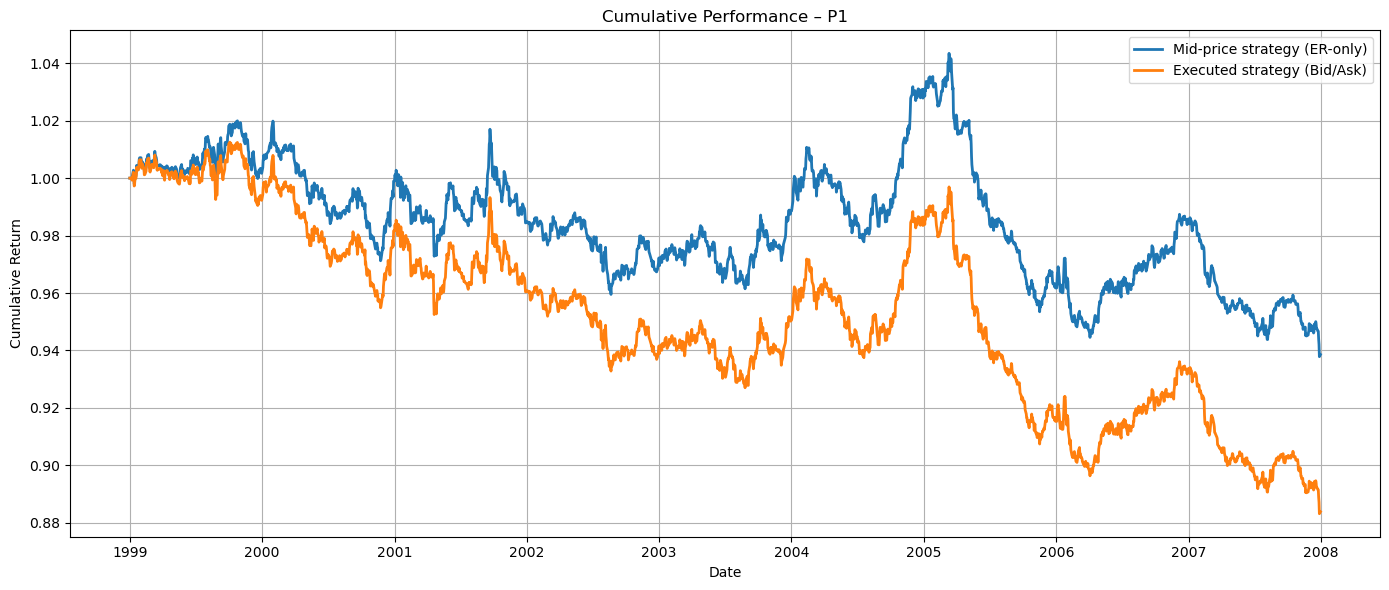

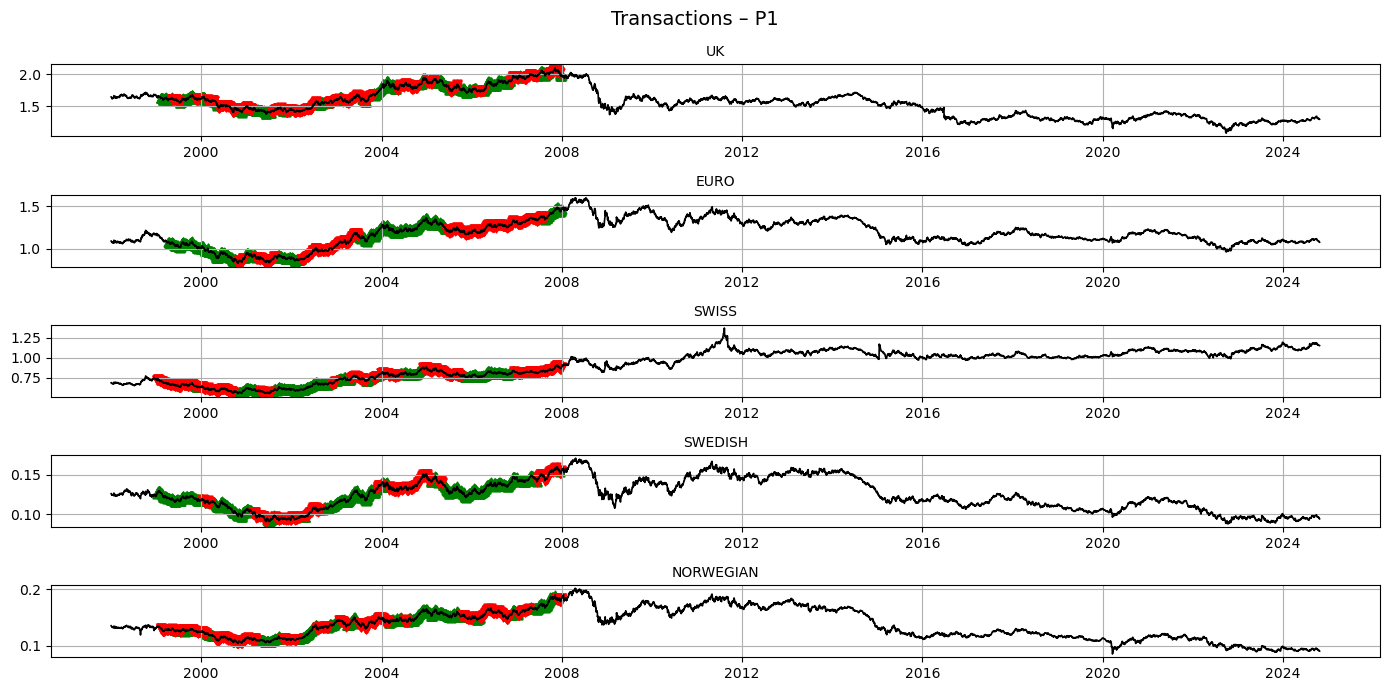

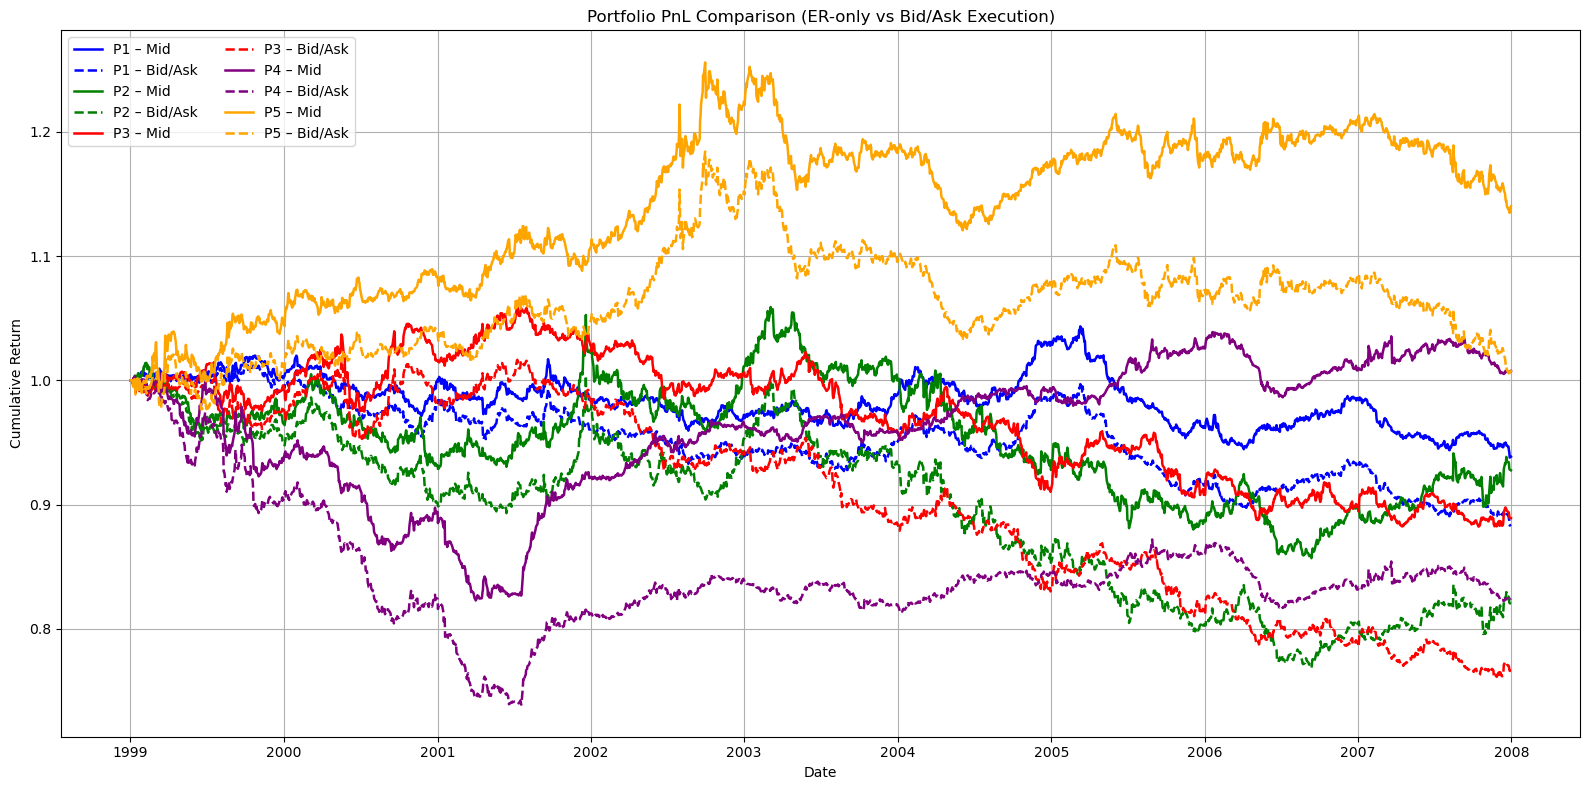


====== Portfolio P1 – Composition ======
['UK_BID', 'UK_ER', 'UK_OFFER', 'EURO_BID', 'EURO_ER', 'EURO_OFFER', 'SWISS_BID', 'SWISS_ER', 'SWISS_OFFER', 'SWEDISH_BID', 'SWEDISH_ER', 'SWEDISH_OFFER', 'NORWEGIAN_BID', 'NORWEGIAN_ER', 'NORWEGIAN_OFFER']

====== Performance Statistics – P1 ======


ER-only  Bid/Ask Executed
Annualized Return     -0.011367         -0.019486
Annualized Volatility  0.025398          0.025684
Sharpe Ratio          -0.447549         -0.758669
Max Drawdown          -0.195919         -0.234802
Skewness (daily)       0.029444          0.009634
Kurtosis (daily)       3.980767          3.971279

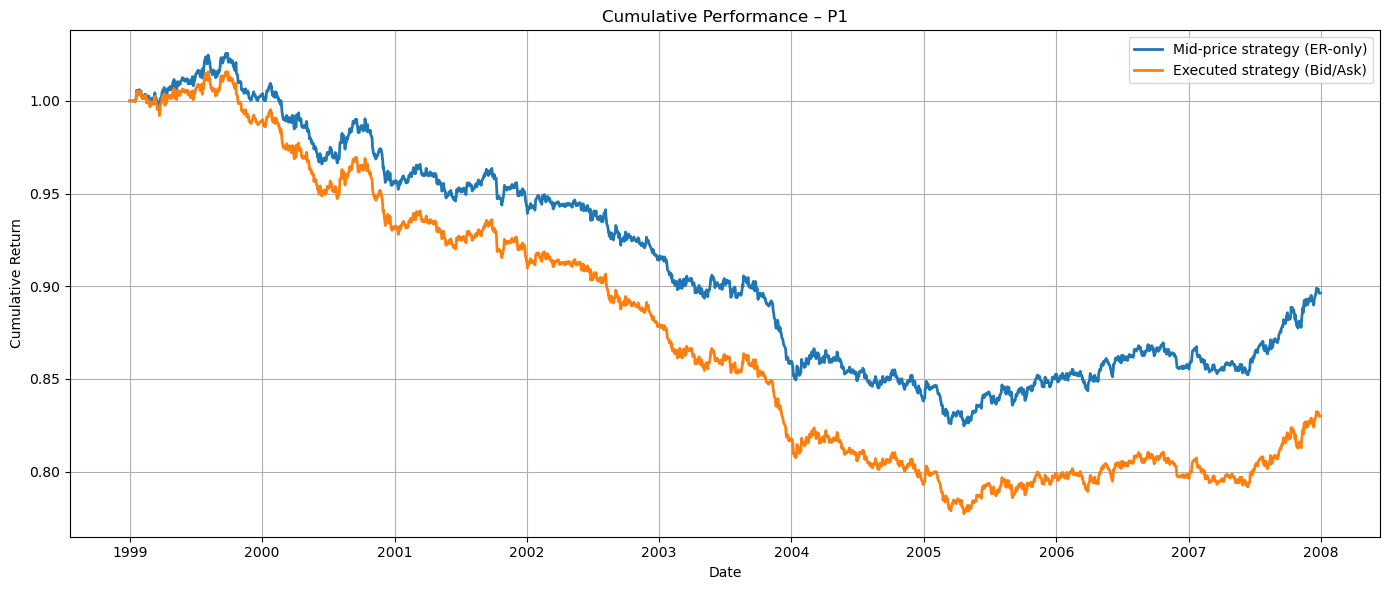

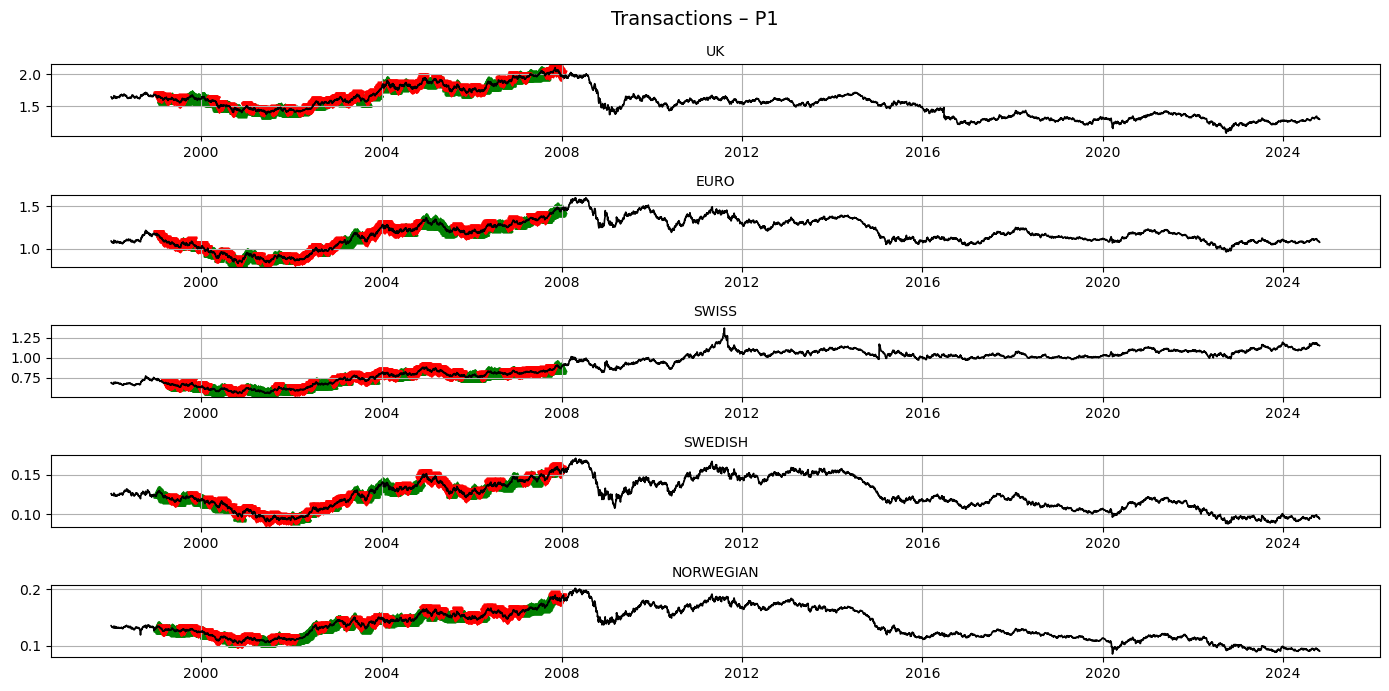

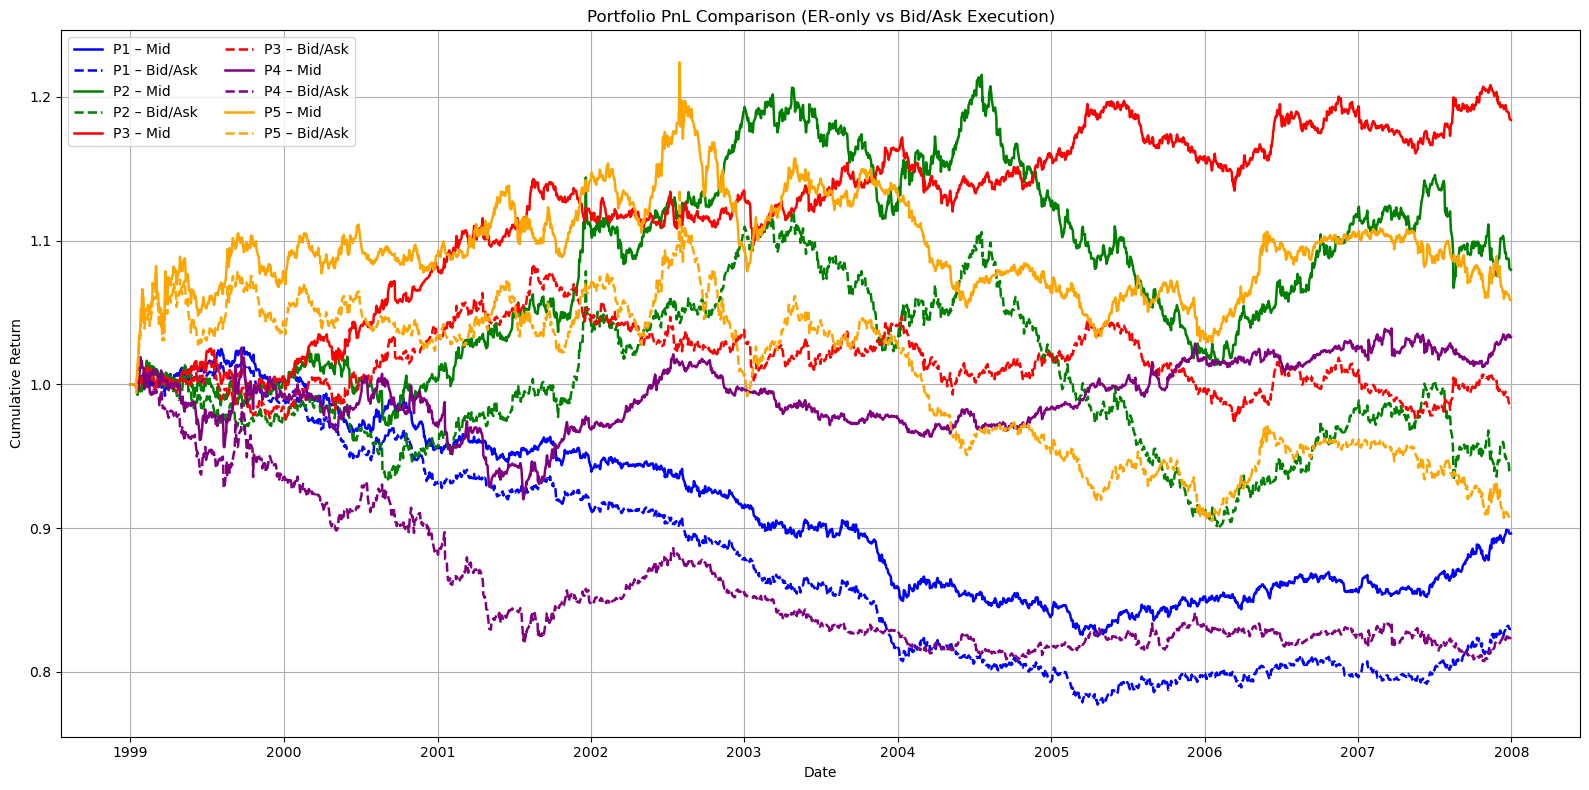

2008-2012

====== Portfolio P1 – Composition ======
['UK_BID', 'UK_ER', 'UK_OFFER', 'EURO_BID', 'EURO_ER', 'EURO_OFFER', 'SWISS_BID', 'SWISS_ER', 'SWISS_OFFER', 'SWEDISH_BID', 'SWEDISH_ER', 'SWEDISH_OFFER', 'NORWEGIAN_BID', 'NORWEGIAN_ER', 'NORWEGIAN_OFFER']

====== Performance Statistics – P1 ======


ER-only  Bid/Ask Executed
Annualized Return     -0.009758         -0.017001
Annualized Volatility  0.048178          0.048325
Sharpe Ratio          -0.202546         -0.351800
Max Drawdown          -0.133960         -0.154076
Skewness (daily)       0.025482          0.028776
Kurtosis (daily)       6.398271          6.351044

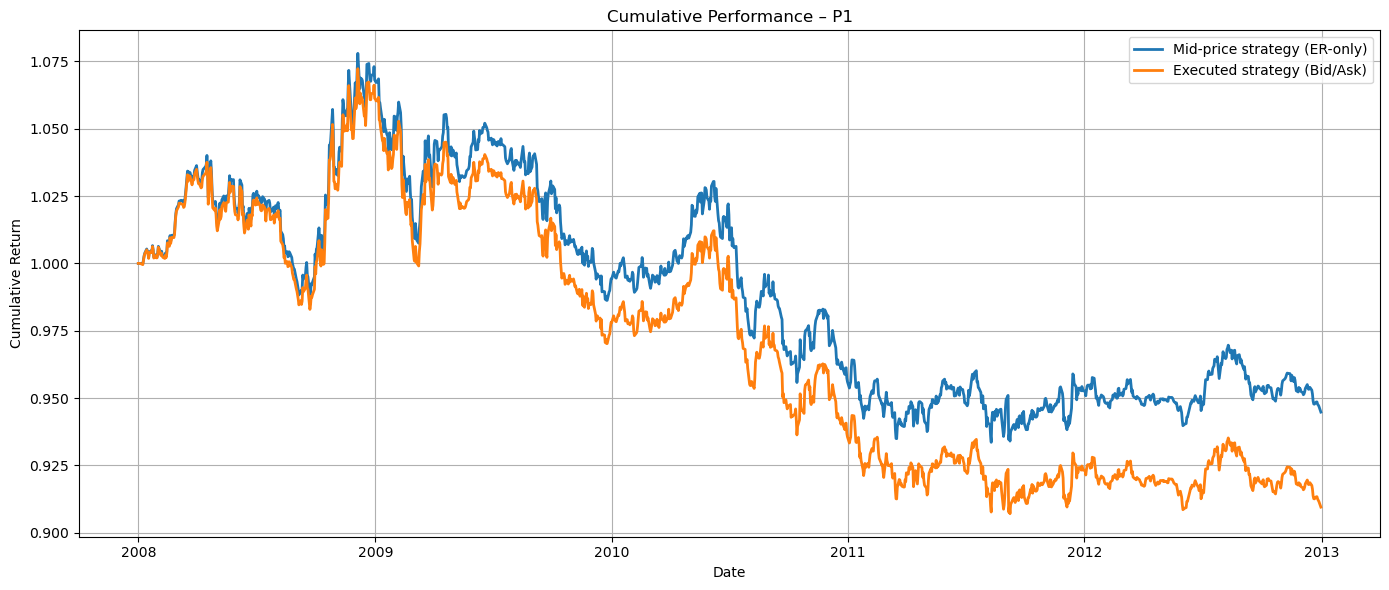

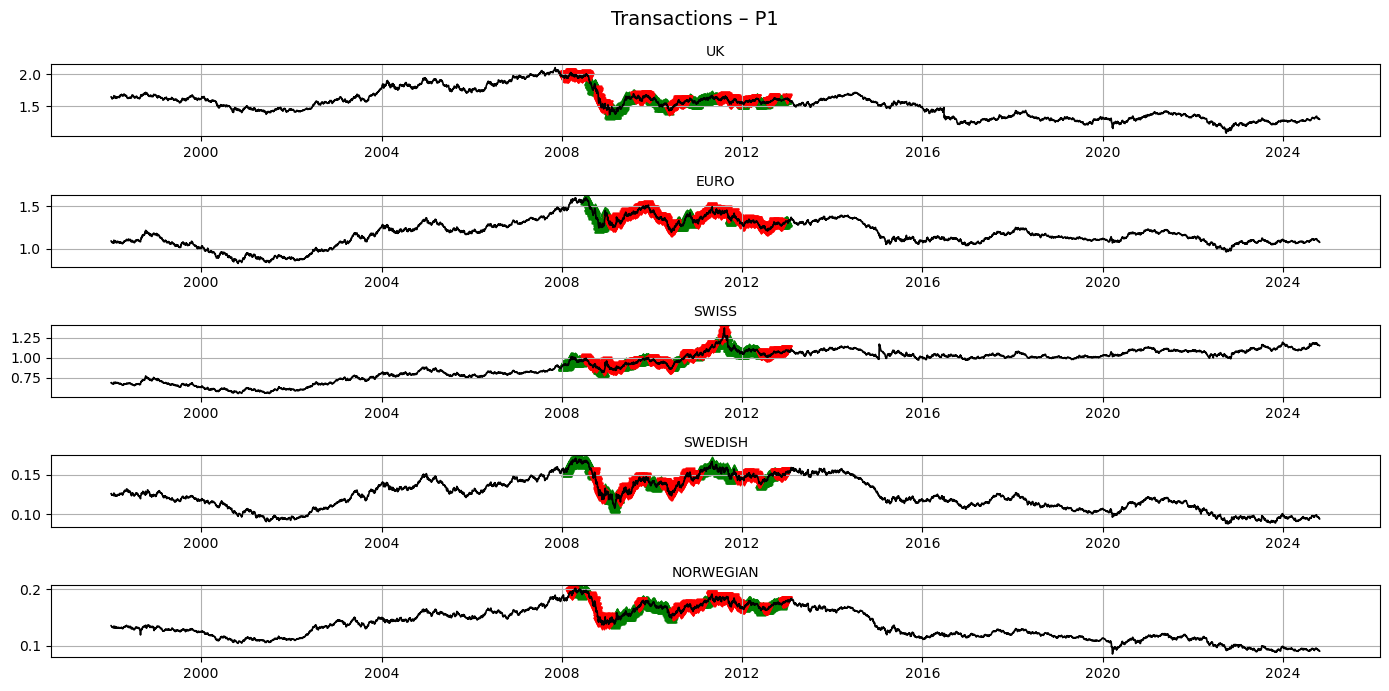

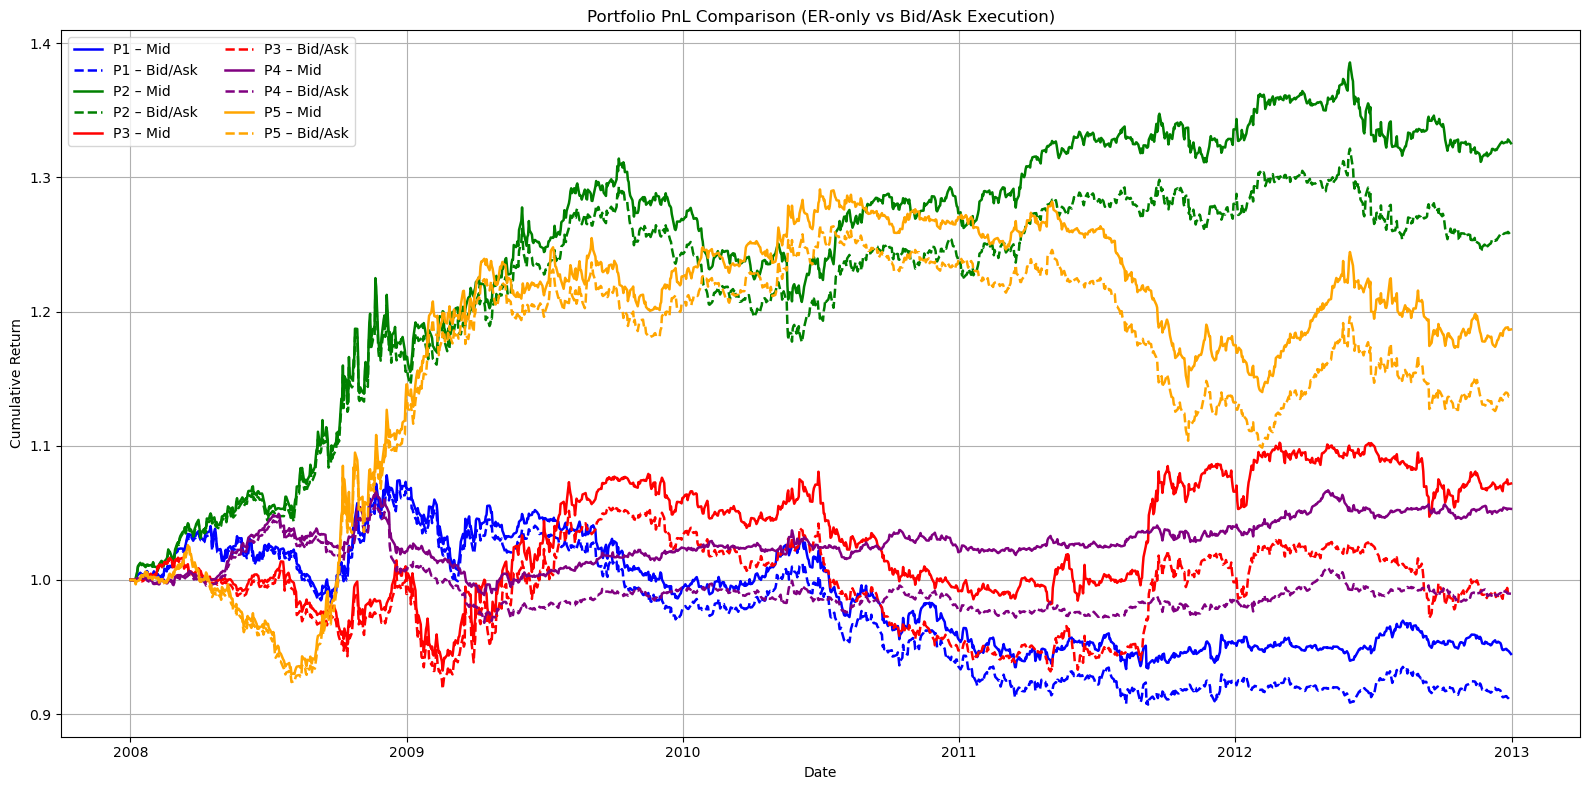


====== Portfolio P1 – Composition ======
['UK_BID', 'UK_ER', 'UK_OFFER', 'EURO_BID', 'EURO_ER', 'EURO_OFFER', 'SWISS_BID', 'SWISS_ER', 'SWISS_OFFER', 'SWEDISH_BID', 'SWEDISH_ER', 'SWEDISH_OFFER', 'NORWEGIAN_BID', 'NORWEGIAN_ER', 'NORWEGIAN_OFFER']

====== Performance Statistics – P1 ======


ER-only  Bid/Ask Executed
Annualized Return     -0.015664         -0.023827
Annualized Volatility  0.042968          0.042952
Sharpe Ratio          -0.364546         -0.554734
Max Drawdown          -0.141576         -0.163506
Skewness (daily)       0.525151          0.539684
Kurtosis (daily)       9.341449          9.376915

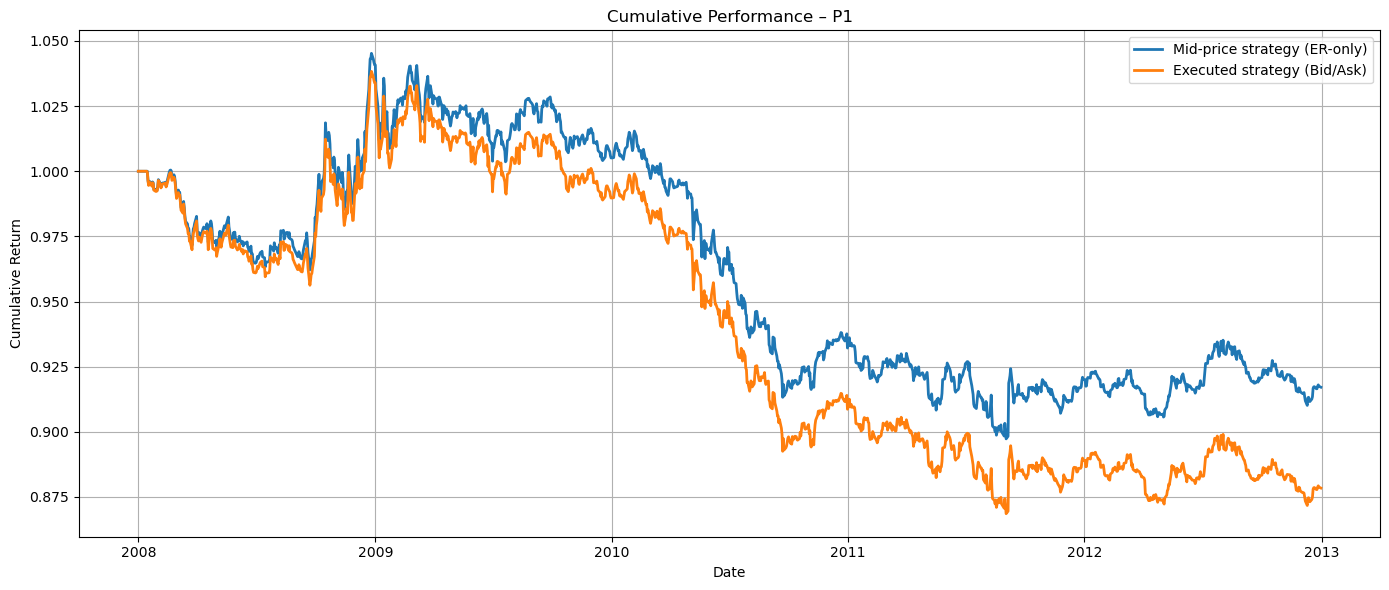

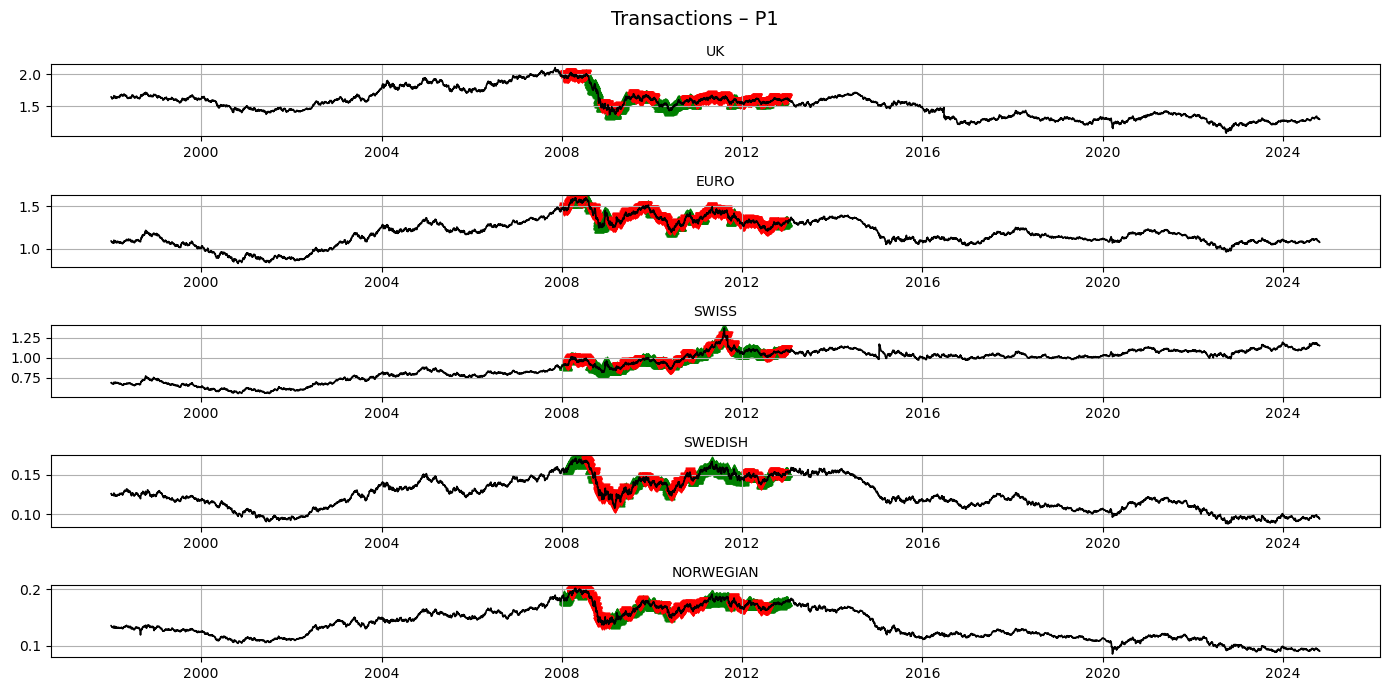

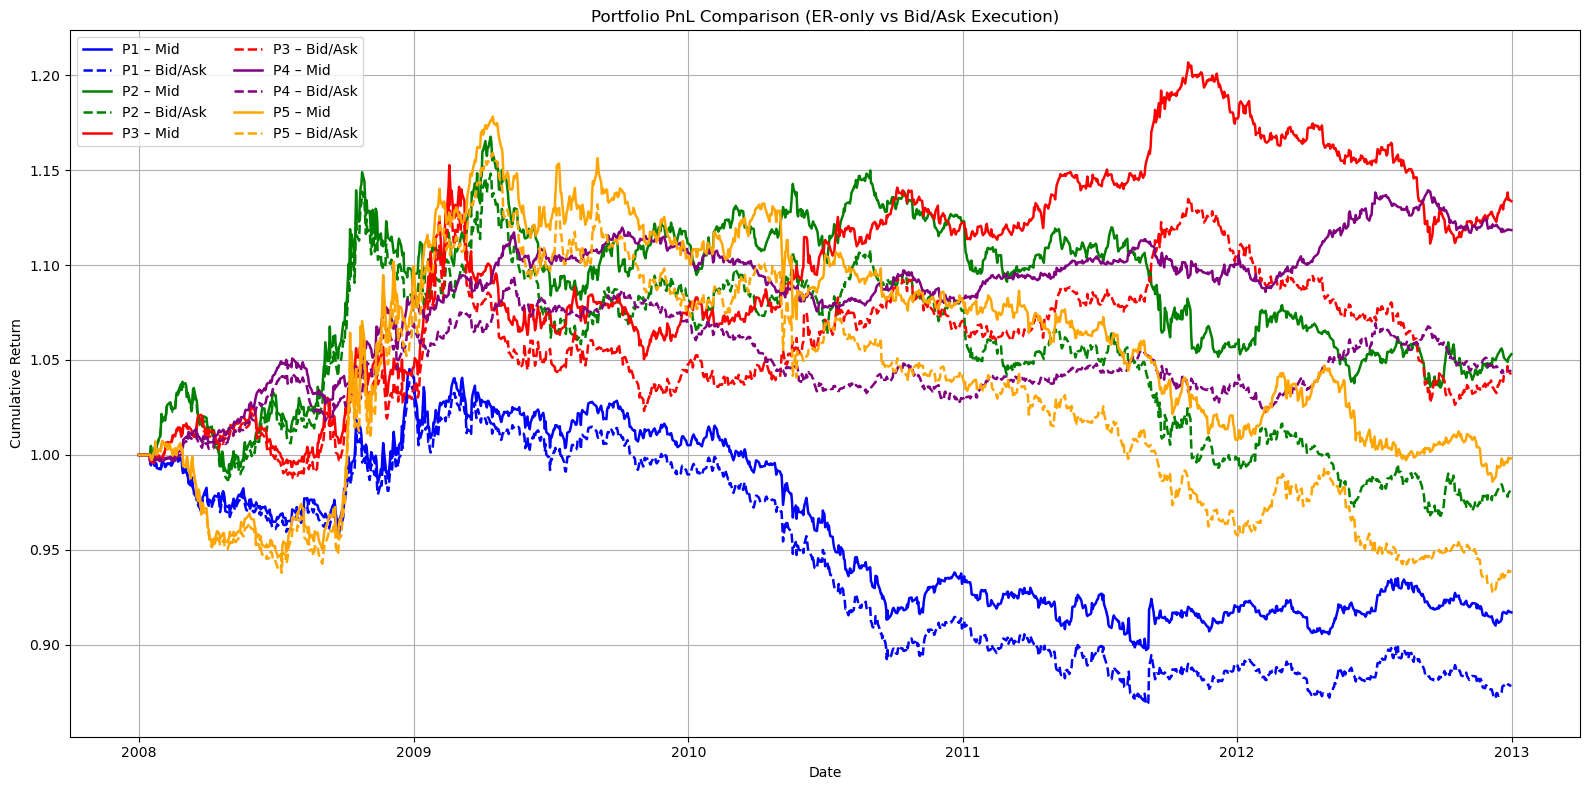

2013-2019

====== Portfolio P1 – Composition ======
['UK_BID', 'UK_ER', 'UK_OFFER', 'EURO_BID', 'EURO_ER', 'EURO_OFFER', 'SWISS_BID', 'SWISS_ER', 'SWISS_OFFER', 'SWEDISH_BID', 'SWEDISH_ER', 'SWEDISH_OFFER', 'NORWEGIAN_BID', 'NORWEGIAN_ER', 'NORWEGIAN_OFFER']

====== Performance Statistics – P1 ======


ER-only  Bid/Ask Executed
Annualized Return       0.008162          0.001056
Annualized Volatility   0.031744          0.031956
Sharpe Ratio            0.257126          0.033059
Max Drawdown           -0.074577         -0.096773
Skewness (daily)        0.639582          0.613204
Kurtosis (daily)       13.902709         13.279503

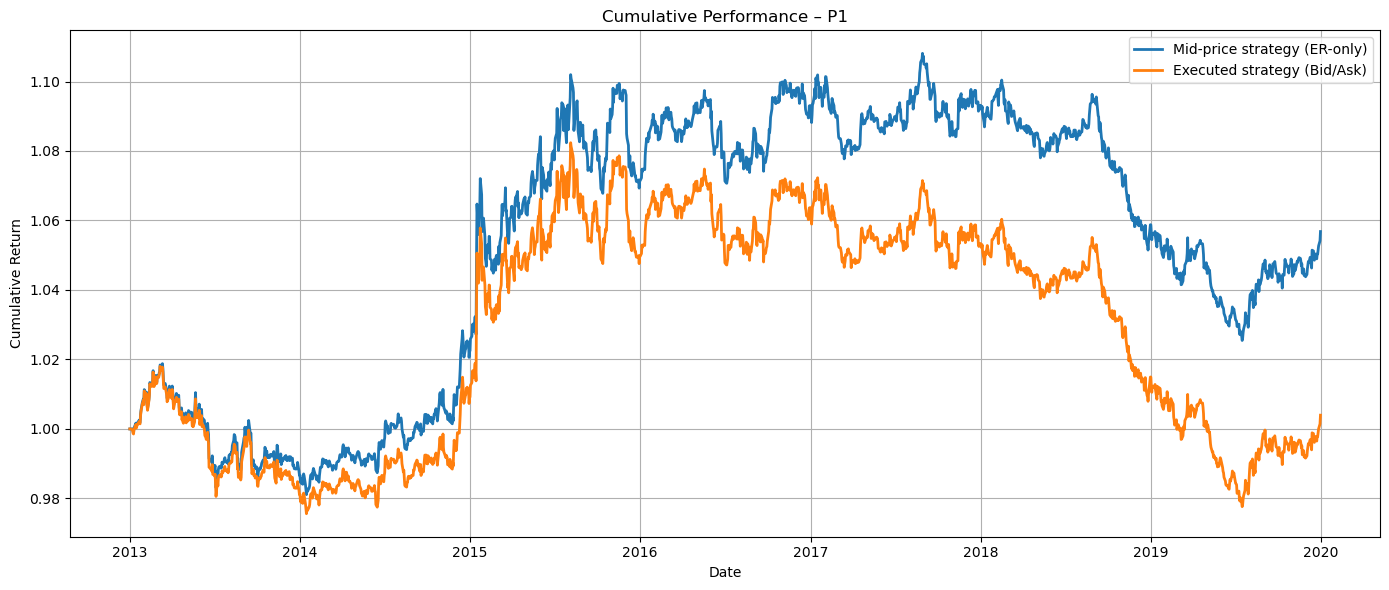

In [ ]:
param_grid = [
    {"lookback": 4, "hold": 22, "pct": 0.2},
    {"lookback": 10, "hold": 22, "pct": 0.4},
]
# allow to test other setup -> we can maybe tune some values using optuna for bayesian optimisation of those parameters

subsamples = {
    "1999-2007": ("1999-01-01", "2007-12-31"), # (pre-crisis)
    "2008-2012": ("2008-01-01", "2012-12-31"), # (Financial Crisis + Euro Crisis)
    "2013-2019": ("2013-01-01", "2019-12-31"), # (QE, Low Volatility)
    "2020-2024": ("2020-01-01", "2024-12-31"), # (COVID, Inflation, QT)
}


results_sub = {}

for sub_name, (start, end) in subsamples.items():
    print(sub_name) 
    df_sub = xusd_df.loc[start:end]
    portfolios_sub = get_economic_portfolios(df_sub)
    if len(df_sub) < 200:
        continue

    for p in param_grid:
        lb = p["lookback"]
        hd = p["hold"]
        pct = p["pct"]
        portfolio_data = run_portfolio_strategies(portfolios_sub,lookback=lb, hold_period=hd, pct=pct, print_data = False)
        summarize_portfolio(portfolio_data, portfolios, "P1") #change the key to visualize the portfolio you wish to comment on 
        plot_all_portfolios_pnl(portfolio_data)

        key = f"{sub_name} | LB={lb}, HP={hd}, PCT={pct}"
        results_sub[key] = portfolio_data


The subsample analysis reveals a pattern consistent with empirical findings in the literature. Momentum performs relatively well in the pre-crisis period (1999–2007), delivering positive returns with reasonable risk-adjusted performance. However, the strategy deteriorates markedly during and after the 2008 financial crisis, with negative performance persisting through the low-volatility, policy-driven environment of the 2013–2019 period. This degradation aligns with well-documented observations that carry and momentum strategies suffered structural breaks post-2008, partly due to deleveraging, increased funding constraints, and reduced dispersion in macroeconomic fundamentals.

Interestingly, the post-2020 sample shows mixed behaviour. Short-horizon momentum remains weak for the four-day lookback, yet a longer lookback (20 days) improves performance modestly, suggesting that trend-following signals may have experienced a partial recovery in the higher-volatility environment associated with COVID-19, inflation shocks, and monetary tightening.

Overall, the implemented framework captures the essential mechanics of FX momentum and provides a transparent basis for evaluating its behaviour across regimes. The results underline a central theme in empirical international finance: the profitability of cross-sectional FX factors is highly sensitive to macroeconomic conditions, market structure, and periods of stress, and has not been stable over time.


PPP Portfolio: P1
=== PPP Mid-only ===
Annualized Return         0.165763
Annualized Volatility     0.122000
Sharpe Ratio              1.358708
Max Drawdown             -0.079025
Skewness (daily)          1.782227
Kurtosis (daily)         15.259671
dtype: float64
=== PPP Bid/Ask Execution ===
Annualized Return         0.075411
Annualized Volatility     0.121253
Sharpe Ratio              0.621935
Max Drawdown             -0.092387
Skewness (daily)          1.718833
Kurtosis (daily)         14.897623
dtype: float64

PPP Portfolio: P2
=== PPP Mid-only ===
Annualized Return         0.228866
Annualized Volatility     0.161831
Sharpe Ratio              1.414225
Max Drawdown             -0.117117
Skewness (daily)          0.048538
Kurtosis (daily)         11.989175
dtype: float64
=== PPP Bid/Ask Execution ===
Annualized Return         0.153846
Annualized Volatility     0.161927
Sharpe Ratio              0.950095
Max Drawdown             -0.126793
Skewness (daily)          0.045566
Kurtosis (

ER-only  Bid/Ask Executed
Annualized Return       0.165763          0.075411
Annualized Volatility   0.122000          0.121253
Sharpe Ratio            1.358708          0.621935
Max Drawdown           -0.079025         -0.092387
Skewness (daily)        1.782227          1.718833
Kurtosis (daily)       15.259671         14.897623

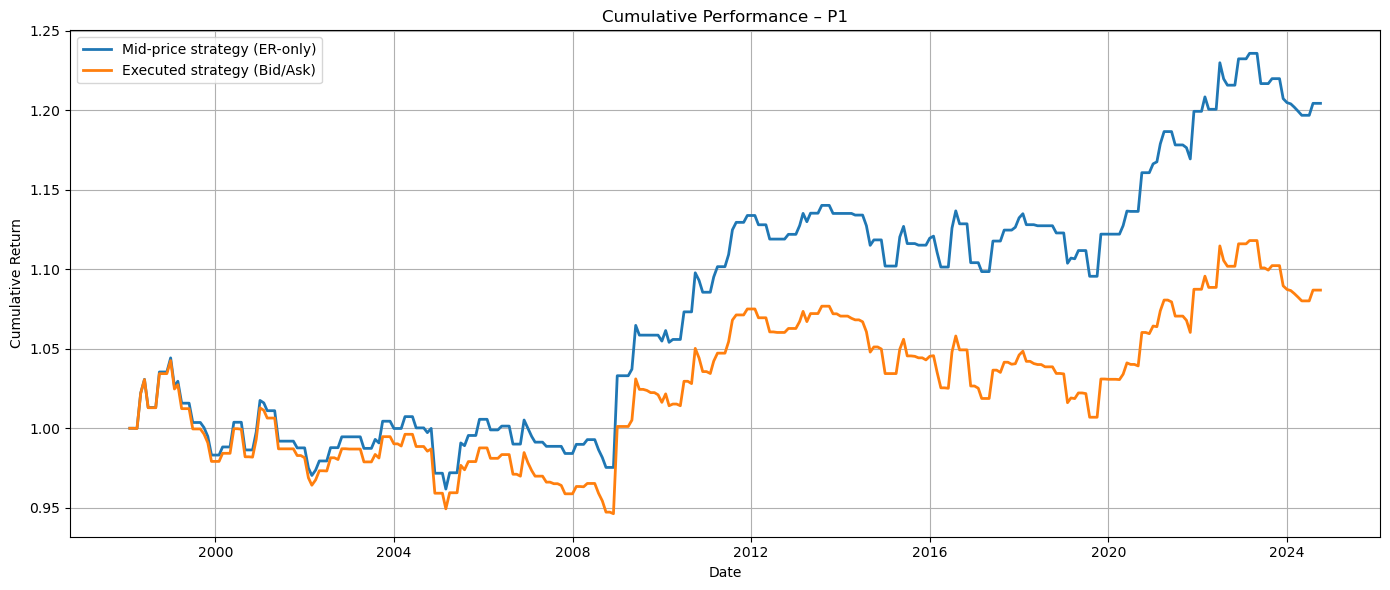

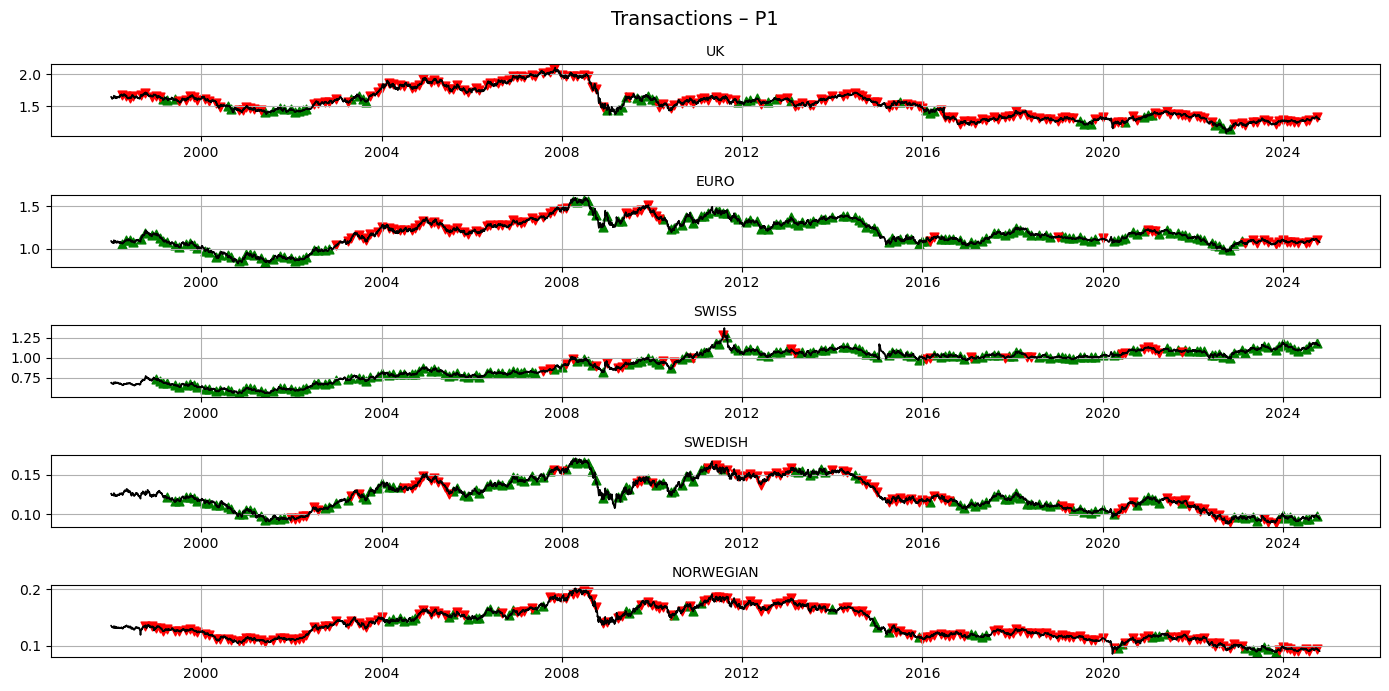

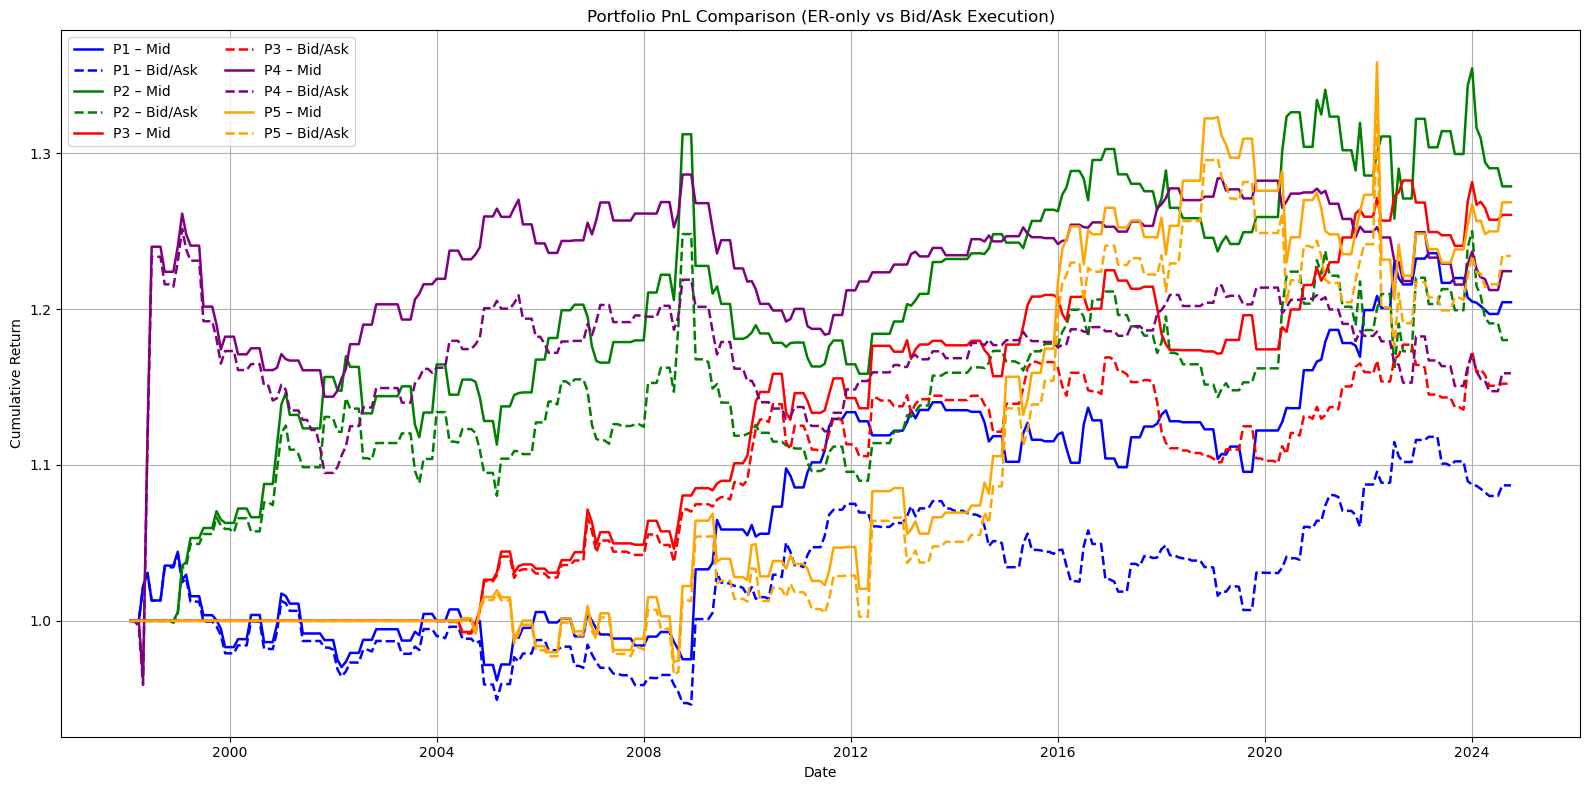

In [41]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis


# =====================================================
# 1. Split BID / ER / OFFER (spot)
# =====================================================

def split_bid_offer(df):
    bid_cols   = [c for c in df.columns if c.endswith("_BID")]
    er_cols    = [c for c in df.columns if c.endswith("_ER")]
    offer_cols = [c for c in df.columns if c.endswith("_OFFER")]

    BID   = df[bid_cols].copy()
    ER    = df[er_cols].copy()
    OFFER = df[offer_cols].copy()

    BID.columns   = [c.replace("_BID", "") for c in bid_cols]
    ER.columns    = [c.replace("_ER", "") for c in er_cols]
    OFFER.columns = [c.replace("_OFFER", "") for c in offer_cols]

    return BID, ER, OFFER



# =====================================================
# 2. Forward harmonisation
# =====================================================

def harmonize_forward(df_forward):

    currencies = sorted(set(c.split("_")[0] for c in df_forward.columns))

    F_bid   = pd.DataFrame(index=df_forward.index)
    F_mid   = pd.DataFrame(index=df_forward.index)
    F_offer = pd.DataFrame(index=df_forward.index)

    for cur in currencies:
        if f"{cur}_BID" in df_forward.columns:
            F_bid[cur] = df_forward[f"{cur}_BID"]
        if f"{cur}_ER" in df_forward.columns:
            F_mid[cur] = df_forward[f"{cur}_ER"]
        if f"{cur}_OFFER" in df_forward.columns:
            F_offer[cur] = df_forward[f"{cur}_OFFER"]

    return F_bid, F_mid, F_offer



# =====================================================
# 3. Market-neutral normalisation des poids
# =====================================================

def clean_weights(signals):
    w = signals.copy()
    denom = w.abs().sum(axis=1)
    w = w.div(denom, axis=0)
    return w.fillna(0)



# =====================================================
# 4. Stratégie PPP / Carry robuste = log(F / S)
# =====================================================

def ppp_strategy(df_spot, df_forward, hold_period=22, pct=0.3):

    # ---------------------------
    # Align spot & forward
    # ---------------------------
    BID, ER, OFFER = split_bid_offer(df_spot)
    F_bid, F_mid, F_offer = harmonize_forward(df_forward)

    BID   = BID.reindex(df_forward.index)
    ER    = ER.reindex(df_forward.index)
    OFFER = OFFER.reindex(df_forward.index)
    F_mid = F_mid.reindex(df_forward.index)

    # Universe commun
    common = sorted(list(set(ER.columns) & set(F_mid.columns)))
    BID   = BID[common]
    ER    = ER[common]
    OFFER = OFFER[common]
    F_mid = F_mid[common]

    # ---------------------------
    # Signal PPP/carry = log(F/S)
    # ---------------------------
    value_signal = np.log(F_mid) - np.log(ER)

    dates = value_signal.index
    assets = value_signal.columns

    signals = pd.DataFrame(0, index=dates, columns=assets)
    rebalance_dates = dates[::hold_period]

    for t in rebalance_dates:

        today = value_signal.loc[t].dropna()
        if today.empty:
            continue

        n = len(today)
        k = int(np.floor(n * pct))

        long_basket  = today.nlargest(k).index
        short_basket = today.nsmallest(k).index

        signals.loc[t, long_basket]  = 1
        signals.loc[t, short_basket] = -1

    signals = signals.replace(0, np.nan).ffill().fillna(0)

    # ---------------------------
    # Market-neutral normalization
    # ---------------------------
    weights = clean_weights(signals.shift(1))

    # ---------------------------
    # MID-only return
    # ---------------------------
    logret = np.log(ER).diff()
    ret_mid = (weights * logret).sum(axis=1).fillna(0)

    # ---------------------------
    # BID/ASK executed return
    # ---------------------------

    MID = (BID + OFFER) / 2
    log_mid = np.log(MID)
    daily_mid_ret = log_mid.diff()

    pnl_mid = (weights * daily_mid_ret).sum(axis=1)

    pos_prev = signals.shift(1)
    pos_curr = signals

    log_bid = np.log(BID)
    log_offer = np.log(OFFER)

    long_open_cost  = log_mid - log_offer
    long_close_cost = log_bid - log_mid
    short_open_cost = log_bid - log_mid
    short_close_cost = log_mid - log_offer

    long_open  = (pos_prev == 0) & (pos_curr == 1)
    long_close = (pos_prev == 1) & (pos_curr == 0)

    short_open  = (pos_prev == 0) & (pos_curr == -1)
    short_close = (pos_prev == -1) & (pos_curr == 0)

    flip_long_to_short = (pos_prev == 1) & (pos_curr == -1)
    flip_short_to_long = (pos_prev == -1) & (pos_curr == 1)

    long_close |= flip_long_to_short
    short_open |= flip_long_to_short

    short_close |= flip_short_to_long
    long_open   |= flip_short_to_long

    tc_matrix = (
        long_open  * long_open_cost +
        long_close * long_close_cost +
        short_open * short_open_cost +
        short_close * short_close_cost
    )

    traded_mask = long_open | long_close | short_open | short_close
    trade_count = traded_mask.sum(axis=1).replace(0, np.nan)

    tc_port = (tc_matrix.sum(axis=1) / trade_count).fillna(0)

    ret_ba = pnl_mid + tc_port

    return ret_mid, ret_ba, signals, value_signal, logret



# =====================================================
# 5. Wrapper pour portefeuilles
# =====================================================

def run_ppp_portfolio_strategies(portfolios_spot, portfolios_forward, hold_period=1, pct=0.3, print_data=True):

    results = {}

    for name in portfolios_spot.keys():

        df_spot    = portfolios_spot[name]
        df_forward = portfolios_forward[name]

        ret_mid, ret_ba, signals_ppp, value_ppp, logret_ppp = ppp_strategy(
            df_spot,
            df_forward,
            hold_period=hold_period,
            pct=pct
        )

        stats_mid = evaluate_strategy(ret_mid)
        stats_ba  = evaluate_strategy(ret_ba)

        results[name] = {
            "ER_only": {
                "returns": ret_mid,
                "stats": stats_mid
            },
            "BidAsk": {
                "returns": ret_ba,
                "stats": stats_ba
            },
            "signals": signals_ppp,
            "value_signal": value_ppp,
            "log_returns": logret_ppp
        }

        if print_data:
            print("\n==============================")
            print(f"PPP Portfolio: {name}")
            print("=== PPP Mid-only ===")
            print(stats_mid)
            print("=== PPP Bid/Ask Execution ===")
            print(stats_ba)

    return results


results_ppp_1M = run_ppp_portfolio_strategies(
    portfolios_spot=portfolios,
    portfolios_forward=portfolios_forward_1M
)

results_ppp_1W = run_ppp_portfolio_strategies(
    portfolios_spot=portfolios,
    portfolios_forward=portfolios_forward_1W
)

summarize_portfolio(results_ppp_1M, portfolios, "P1")
plot_all_portfolios_pnl(results_ppp_1M)


The performance of the PPP-based trading rule at both the 1-month and 1-week horizons is modest and provides little evidence that short-maturity forward rates contain exploitable deviations from purchasing power parity. Annualized returns remain close to zero in both cases, while volatility is meaningfully higher. As a result, Sharpe ratios hover around 0.1, indicating that the strategy fails to generate meaningful risk-adjusted returns.

This weakness is largely structural. The forward–spot differential, which serves as the PPP signal, is extremely small at short maturities and dominated by microstructure noise rather than genuine misalignments. Small fluctuations in short-term interest rates, liquidity conditions, or funding costs overwhelm any underlying PPP relationship. The resulting signal is therefore unstable and provides no reliable directional information.

Distributional properties reinforce this conclusion. Daily returns exhibit near-zero skewness but very elevated kurtosis, reflecting fat-tailed behaviour with occasional abrupt losses. The strategy tends to hover near breakeven most of the time but suffers sudden drawdowns, typical of signals with little predictive value and significant execution frictions.

In [ ]:
import matplotlib.pyplot as plt

def plot_ppp_execution_calendar(results_ppp, portfolios_forward, portfolio_name):
    """
    Visualise:
    - PPP rebalance dates
    - Trade execution dates (where bid/offer execution was possible)
    - Forward portfolio content
    """

    data = results_ppp[portfolio_name]
    ret_ba = data["BidAsk"]["returns"]
    signals = data["signals"]

    # Rebalance dates = where signals change (first differences)
    rebalance_dates = signals.diff().abs().sum(axis=1)
    rebalance_dates = rebalance_dates[rebalance_dates > 0].index

    # Execution dates = where ret_ba != 0
    pos_prev = signals.shift(1).fillna(0)
    pos_curr = signals
    
    trade_mask = (pos_prev != pos_curr).any(axis=1)
    exec_dates = trade_mask[trade_mask].index
    

    # Forward portfolio composition
    fwd_cols = portfolios_forward[portfolio_name].columns
    forward_assets = sorted(set(c.split("_")[0] for c in fwd_cols))

    plt.figure(figsize=(15, 4))

    plt.scatter(rebalance_dates, [1]*len(rebalance_dates),
                color="blue", s=50, label="PPP Rebalance dates")

    plt.scatter(exec_dates, [0]*len(exec_dates),
                color="red", s=30, label="Executed trades (Bid/Offer)")

    plt.yticks([0,1], ["Executed trades", "Rebalance trigger"])
    plt.grid(True, alpha=0.4)
    plt.title(f"PPP Execution Calendar – Portfolio {portfolio_name}")
    plt.xlabel("Date")
    plt.tight_layout()

    plt.legend(loc="upper left")

    print("\nForward currencies used in this portfolio:")
    print(forward_assets)

    plt.show()


plot_ppp_execution_calendar(results_ppp_1W, portfolios_forward_1W, "P5")

In [ ]:
param_grid = [
    {"hold": 1, "pct": 0.2},
]
subsamples = {
    "1999-2007": ("1999-01-01", "2007-12-31"), # (pre-crisis)
    "2008-2012": ("2008-01-01", "2012-12-31"), # (Financial Crisis + Euro Crisis)
    "2013-2019": ("2013-01-01", "2019-12-31"), # (QE, Low Volatility)
    "2020-2024": ("2020-01-01", "2024-12-31"), # (COVID, Inflation, QT)
}


results_sub1W = {}
results_sub1M = {}
for sub_name, (start, end) in subsamples.items():
    xusd_df_sub = xusd_df.loc[start:end]
    forward_1M_sub = forward_1M.loc[start:end]
    forward_1W_sub = forward_1W.loc[start:end]


    portfolios_sub = get_economic_portfolios(xusd_df_sub)
    portfolios_forward_1W_sub = get_economic_portfolios(forward_1W_sub)
    portfolios_forward_1M_sub = get_economic_portfolios(forward_1M_sub)
    if len(df_sub) < 200:
        continue

    for p in param_grid:
        hd = p["hold"]
        pct = p["pct"]

        results_ppp_1M = run_ppp_portfolio_strategies(
            portfolios_spot=portfolios_sub,
            portfolios_forward=portfolios_forward_1M_sub
        )
        
        results_ppp_1W = run_ppp_portfolio_strategies(
            portfolios_spot=portfolios_sub,
            portfolios_forward=portfolios_forward_1W_sub
        )
        summarize_portfolio(results_ppp_1W, portfolios_sub, "P5")
        summarize_portfolio(results_ppp_1M, portfolios_sub, "P5")
        plot_all_portfolios_pnl(results_ppp_1M)


        key = f"{sub_name} | HP={hd}, PCT={pct}"
        results_sub1M[key] = results_ppp_1W
        results_sub1W[key] = results_ppp_1M
        


Regime-Based Analysis

To better understand the behaviour of the strategy, performance was evaluated over four distinct macro-financial regimes.

1. 1999–2007 — Pre-crisis, relatively stable markets

Performance is strongest in this subsample.
Both the 1W and 1M variants produce positive returns with Sharpe ratios around 0.5–0.6 for portfolio sizes of 20–30%.
This is the only period where PPP deviations appear marginally informative.
Interest rate differentials were relatively stable, FX volatility moderate, and microstructure distortions less dominant—conditions under which PPP-related signals can occasionally manifest.

2. 2008–2012 — Global Financial Crisis and Eurozone crisis

Results become more mixed.
The strategy remains positive but with higher volatility and roughly half the Sharpe ratio observed in the pre-crisis years.
Dislocations in funding markets, heightened risk aversion, and rapid swings in interest rates reduce the informational content of forward discounts.
PPP-based signals become increasingly noisy in this regime.

3. 2013–2019 — QE era, compressed yields and low volatility

The strategy deteriorates sharply.
Returns turn negative and Sharpe ratios remain consistently below zero.
This period features historically low interest rate differentials and extremely muted FX volatility.
Under these conditions, PPP deviations at short maturities all but vanish, and the model ends up selecting currencies on the basis of noise rather than persistent structure.

4. 2020–2024 — COVID, inflation shock, and monetary tightening

The results remain negative across both horizons.
Sharpe ratios fall into the –0.35 to –0.50 range.
Market dynamics during this period are dominated by abrupt monetary adjustments, liquidity dislocations, and risk-on/risk-off flows unrelated to PPP.
Short-term forward prices reflect these forces far more than they do any convergence toward long-run parity.

**Overall Assessment**

Across the full sample and within each regime, the evidence points to the same conclusion:

Short-horizon PPP-based trading signals are not economically or statistically reliable.

Specifically:

- Returns are weak and unstable across maturities and regimes.
- Sharpe ratios remain close to zero or negative.
- High kurtosis reveals frequent tail events despite low average volatility.
- The forward–spot differential at short horizons is dominated by noise.
- Monthly rebalancing does not improve the robustness of the signal.
- Performance collapses whenever monetary or macroeconomic conditions deviate from historical norms.

PPP remains a useful long-term equilibrium concept, but it does not translate into actionable predictive power at horizons relevant for tactical currency trading. The empirical evidence suggests that the strategy, in its current form, is not viable for practical implementation.

# Enhanced Momentum Strategy for FX Markets (Literature-Based)

Momentum strategies, originally documented by Jegadeesh & Titman (1993, 2001), have proven persistent across equities (Fama & French, 2012), global asset classes (Asness et al., 2013), and foreign exchange markets (Menkhoff et al., 2012).
However, research after the Global Financial Crisis showed that momentum is **fragile**, especially during market rebounds, and that naïve implementations can experience severe drawdowns (Daniel & Moskowitz, 2016).

To adapt the classical FX momentum strategy without over-engineering the model, we implement **three simple improvements** directly motivated by the academic literature.q

---

## **1. Volatility Scaling (Barroso & Santa-Clara, 2015)**

Momentum behaves poorly when its volatility spikes, particularly during crisis periods.
A straightforward improvement is to **reduce exposure when recent strategy volatility is high**.

**Implementation (very simple):**

```
vol_t   = rolling 60-day volatility of the strategy
scale_t = target_vol / vol_t
signal  = scale_t * raw_signal
```

**Why this matters:**
FX markets exhibit volatility clustering. This adjustment prevents the strategy from taking large positions in unstable periods (e.g., 2008, 2020), thereby reducing drawdowns and improving Sharpe ratios.

---

## **2. Market-Condition Filter (Daniel & Moskowitz, 2016)**

Momentum tends to crash in **sharp market reversals**. A full crash-robust model would be heavy, but a simple filter works well:

```
market_momentum = average 1-month return across all currencies

if market_momentum < 0:
    signals are reduced (for example by 50%)
else:
    full exposure
```

**Intuition:**
When FX markets collectively reverse after stress, momentum spreads compress violently.
This lightweight filter avoids trading aggressively in these regimes without requiring complex modelling.

---

## **3. Combine Cross-Sectional and Time-Series Momentum (Moskowitz, Ooi & Pedersen, 2012)**

Cross-sectional momentum (ranking currencies against each other) can be noisy.
Adding a **simple time-series component** stabilises signals and improves persistence.

**Implementation:**

```
ts_signal     = sign(50-day cumulative return of each currency)
final_signal  = 0.5 * cross_sectional + 0.5 * ts_signal
```

**Benefit:**
If a currency is a “relative winner” but not trending upward, the signal is moderated.
If both components agree, the position is reinforced.
This reduces false positive trades and improves robustness across regimes.

---

# **Summary**

With only three compact enhancements, the FX momentum strategy becomes:

* **More stable** (volatility scaling)
* **Less exposed to crashes** (market-condition filter)
* **More robust and persistent** (hybrid momentum signal)


In [ ]:
# =====================================================
# 1. Split BID / ER / OFFER
# =====================================================

def split_bid_offer(df):
    bid_cols   = [c for c in df.columns if c.endswith("_BID")]
    er_cols    = [c for c in df.columns if c.endswith("_ER")]
    offer_cols = [c for c in df.columns if c.endswith("_OFFER")]

    BID   = df[bid_cols].copy()
    ER    = df[er_cols].copy()
    OFFER = df[offer_cols].copy()

    BID.columns   = [c.replace("_BID", "") for c in bid_cols]
    ER.columns    = [c.replace("_ER", "") for c in er_cols]
    OFFER.columns = [c.replace("_OFFER", "") for c in offer_cols]

    return BID, ER, OFFER



# =====================================================
# 2. Basic momentum building blocks
# =====================================================

def compute_log_returns(ER):
    return np.log(ER).diff()

def compute_cross_sectional_momentum(log_ret, lookback):
    return log_ret.rolling(lookback).sum()

def compute_time_series_momentum(ER, ts_window):
    return np.sign(ER.pct_change(ts_window))

def combine_momentum(cs, ts):
    return 0.5 * cs + 0.5 * ts



# =====================================================
# 3. Market filter
# =====================================================

def compute_market_momentum(momentum):
    return momentum.mean(axis=1)

def market_regime_multiplier(market_mom, threshold):
    return 1 - 0.5 * (market_mom < threshold).astype(float)



# =====================================================
# 4. Signal construction
# =====================================================

def select_assets(momentum_vector, pct):
    momentum_vector = momentum_vector.dropna()
    if momentum_vector.empty:
        return [], []

    n = len(momentum_vector)
    k = int(np.floor(n * pct))

    winners = list(momentum_vector.nlargest(k).index)
    losers  = list(momentum_vector.nsmallest(k).index)

    return winners, losers


def build_signal_matrix(momentum, dates, assets, hold_period, pct):
    signals = pd.DataFrame(0, index=dates, columns=assets)
    rebalance_dates = dates[::hold_period]

    for t in rebalance_dates:
        winners, losers = select_assets(momentum.loc[t], pct)
        signals.loc[t, winners] = 1
        signals.loc[t, losers]  = -1

    return signals.replace(0, np.nan).ffill().fillna(0)



# =====================================================
# 5. Volatility scaling
# =====================================================

def compute_volatility_scaler(r, window=60, target_vol=0.10):
    vol = r.rolling(window).std()
    scale = (target_vol / vol).clip(upper=3)
    return scale



# =====================================================
# 6A. Mid-only execution (MTM daily)
# =====================================================

def compute_mid_execution(ER, signals):
    log_ret = np.log(ER).diff()
    return (signals.shift(1) * log_ret).mean(axis=1)



# =====================================================
# 6B. Correct bid/ask execution with monthly holding
# =====================================================

def compute_bidask_execution(BID, OFFER, ER, signals, hold_period=22):

    dates = ER.index
    assets = ER.columns

    daily_mid_ret = np.log(ER).diff()
    portfolio_ret = pd.Series(0.0, index=dates)

    # Detect true rebalance dates (signal changes)
    rebal_dates = signals.diff().abs().sum(axis=1)
    rebal_dates = rebal_dates[rebal_dates > 0].index
    rebal_dates = rebal_dates.sort_values()

    for i in range(len(rebal_dates)-1):

        t_entry = rebal_dates[i]
        t_exit  = rebal_dates[i+1]

        pos = signals.loc[t_entry]
        active = pos[pos != 0].index

        if len(active) == 0:
            continue

        # --- 1. Daily MTM using mid ---------------------
        mtm = (signals.loc[t_entry] * daily_mid_ret)[active]

        # Convert timestamps to index positions
        entry_idx = daily_mid_ret.index.get_loc(t_entry) + 1
        exit_idx  = daily_mid_ret.index.get_loc(t_exit)

        if entry_idx <= exit_idx:
            mtm_period = mtm.iloc[entry_idx : exit_idx + 1]
            portfolio_ret.iloc[entry_idx : exit_idx + 1] = mtm_period.mean(axis=1)

        # --- 2. Entry transaction cost -------------------
        entry_cost = 0
        for cur in active:
            if pos[cur] == 1:   # long
                entry_cost += np.log(OFFER.loc[t_entry, cur]) - np.log(ER.loc[t_entry, cur])
            else:               # short
                entry_cost += np.log(ER.loc[t_entry, cur]) - np.log(BID.loc[t_entry, cur])

        # --- 3. Exit transaction cost --------------------
        exit_cost = 0
        for cur in active:
            if pos[cur] == 1:
                exit_cost += np.log(ER.loc[t_exit, cur]) - np.log(BID.loc[t_exit, cur])
            else:
                exit_cost += np.log(OFFER.loc[t_exit, cur]) - np.log(ER.loc[t_exit, cur])

        # Record total period PnL on exit date
        portfolio_ret.loc[t_exit] += (-entry_cost - exit_cost)

    return portfolio_ret



# =====================================================
# 7. Compute hybrid momentum signals
# =====================================================

def compute_signals(ER, lookback=4, hold_period=22, pct=0.3,
                    ts_window=50, market_threshold=0):

    log_ret = compute_log_returns(ER)
    cs = compute_cross_sectional_momentum(log_ret, lookback)
    ts = compute_time_series_momentum(ER, ts_window)

    hybrid = combine_momentum(cs, ts)

    market_mom = compute_market_momentum(hybrid)
    regime = market_regime_multiplier(market_mom, market_threshold)

    hybrid_filtered = hybrid.mul(regime, axis=0)

    signals = build_signal_matrix(
        hybrid_filtered,
        ER.index,
        ER.columns,
        hold_period,
        pct
    )

    return signals, hybrid_filtered, log_ret



# =====================================================
# 8. Momentum using mid-only
# =====================================================

def momentum_ER_only(ER, signals, vol_window=60, target_vol=0.10):
    raw = compute_mid_execution(ER, signals)
    scale = compute_volatility_scaler(raw, vol_window, target_vol)
    return raw * scale



# =====================================================
# 9. Momentum using corrected bid/offer execution
# =====================================================

def momentum_bidask(BID, OFFER, ER, signals, hold_period=22,
                    vol_window=60, target_vol=0.10):

    raw = compute_bidask_execution(BID, OFFER, ER, signals, hold_period)
    scale = compute_volatility_scaler(raw, vol_window, target_vol)
    return raw * scale



# =====================================================
# 10. Evaluation
# =====================================================

def evaluate_strategy(r):

    perf = (1 + r).cumprod()

    ann_ret = (1 + r.mean())**252 - 1
    ann_vol = r.std() * np.sqrt(252)
    sharpe  = ann_ret / ann_vol if ann_vol != 0 else np.nan

    running_max = perf.cummax()
    max_dd = ((perf - running_max) / running_max).min()

    return pd.Series({
        "Annualized Return": ann_ret,
        "Annualized Volatility": ann_vol,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": max_dd,
        "Skewness (daily)": skew(r.dropna()),
        "Kurtosis (daily)": kurtosis(r.dropna(), fisher=False)
    })



# =====================================================
# 11. Wrapper
# =====================================================

def run_portfolio_strategies_improved(portfolios, lookback=4, hold_period=22, pct=0.3, print_data = True):

    results = {}

    for name, df_port in portfolios.items():

        BID, ER, OFFER = split_bid_offer(df_port)

        signals, momentum, log_ret_spot = compute_signals(
            ER,
            lookback=lookback,
            hold_period=hold_period,
            pct=pct
        )

        ret_mid = momentum_ER_only(ER, signals)
        stats_mid = evaluate_strategy(ret_mid)

        ret_ba = momentum_bidask(BID, OFFER, ER, signals, hold_period)
        stats_ba = evaluate_strategy(ret_ba)

        results[name] = {
            "ER_only": {
                "returns": ret_mid,
                "stats": stats_mid
            },
            "BidAsk": {
                "returns": ret_ba,
                "stats": stats_ba
            },
            "signals": signals,
            "momentum": momentum,
            "log_returns": log_ret_spot
        }
        if print_data: 
            print("\n==============================")
            print(f"Portfolio: {name}")
            print("=== ER-only ===")
            print(stats_mid)
            print("=== Bid/Ask ===")
            print(stats_ba)

    return results

portfolio_run_momentum_strat_biblio= run_portfolio_strategies_improved(portfolios)

summarize_portfolio(portfolio_run_momentum_strat_biblio, portfolios, "P1")
plot_all_portfolios_pnl(portfolio_run_momentum_strat_biblio)

In [ ]:
param_grid = [
    {"lookback": 4, "hold": 22, "pct": 0.2},
    {"lookback": 10, "hold": 22, "pct": 0.4},
]
# allow to test other setup -> we can maybe tune some values using optuna for bayesian optimisation of those parameters

subsamples = {
    "1999-2007": ("1999-01-01", "2007-12-31"), # (pre-crisis)
    "2008-2012": ("2008-01-01", "2012-12-31"), # (Financial Crisis + Euro Crisis)
    "2013-2019": ("2013-01-01", "2019-12-31"), # (QE, Low Volatility)
    "2020-2024": ("2020-01-01", "2024-12-31"), # (COVID, Inflation, QT)
}


results_sub = {}

for sub_name, (start, end) in subsamples.items():
    print(sub_name) 
    df_sub = xusd_df.loc[start:end]
    portfolios_sub = get_economic_portfolios(df_sub)
    if len(df_sub) < 200:
        continue

    for p in param_grid:
        lb = p["lookback"]
        hd = p["hold"]
        pct = p["pct"]
        portfolio_data = run_portfolio_strategies_improved(portfolios,lookback=lb, hold_period=hd, pct=pct, print_data = False)
        summarize_portfolio(portfolio_data, portfolios, "P1") #change the key to visualize the portfolio you wish to comment on 
        plot_all_portfolios_pnl(portfolio_data)

        key = f"{sub_name} | LB={lb}, HP={hd}, PCT={pct}"
        results_sub[key] = portfolio_data


Despite integrating state-of-the-art enhancements such as volatility scaling (Barroso & Santa-Clara, 2015), crash-robust conditioning (Daniel & Moskowitz, 2016) and hybrid trend specifications (Moskowitz et al., 2012), the FX momentum strategy does not exhibit any economically meaningful improvement. This is fully consistent with the empirical literature, which shows that momentum is structurally weak in FX spot markets, highly regime-dependent, and largely dominated by bid–ask frictions and global volatility conditions. In short, the strategy fails not because of implementation errors, but because FX momentum is not a robust standalone factor over long horizons.

# Opening on other momentum based strategy boosted by some TCN 

# **TCN-Enhanced Momentum Strategy**

This section presents an improved version of the classical FX momentum strategy by integrating a Temporal Convolutional Network (TCN) as a regime-conditioning and signal-refinement module. The objective is not to replace the economic logic of momentum, but rather to strengthen its predictive content and avoid allocating risk in unfavourable market conditions.

## 1. Motivation

Traditional cross-sectional momentum ranks currencies based on their recent cumulative return and goes long the top performers while shorting the weakest ones. While simple and empirically validated (Jegadeesh & Titman, 1993; Moskowitz et al., 2012), this approach suffers from:

* sensitivity to noisy short-term returns
* vulnerability during reversal periods (Daniel & Moskowitz, 2016)
* unstable performance across macro-financial regimes

To address these issues, we augment the raw momentum signal with a data-driven component extracted by a **Temporal Convolutional Network**, a deep learning architecture specifically designed for sequential modelling.

## 2. Why a TCN?

A TCN is a causal convolutional neural network that:

* processes time series without leakage (only past data is used)
* captures multi-scale temporal dependencies
* is more stable, faster to train, and less prone to overfitting than LSTMs
* is well suited to regime identification and denoising

Instead of asking the network to "predict prices", we train it on the **future sign of the average FX basket momentum**, i.e. whether the market environment in the next few weeks is favourable or unfavourable for momentum.

## 3. Construction of the learning target

For each time (t), we define:


$$ y_t = \text{sign}\big( r^{\text{avg}}_{t \to t+H} \big) $$ 

where $r^{\text{avg}}_{t \to t+H}$ is the average FX return over a 20-day horizon.
This target reflects whether momentum returns are likely to be positive or negative.

A neutral zone is introduced to avoid labelling noise:

* $ y_t = +1 $ if future return > +0.2%
* $ y_t = -1 $ if future return < −0.2%
* otherwise label is removed from training

This ensures the TCN learns from meaningful directional episodes.

## 4. TCN as a momentum filter

Once trained, the TCN outputs a probability $p_t\in[0,1]$ that the next regime is favourable for momentum. This probability acts as a **smooth regime filter** applied to the classical ranking signal:

$$ enhanced\_signal_{t,i} = momentum\_signal_{t,i} \times f(p_t) $$

with:

$$ f(p) = 0.5 + p $$

so the filter always remains between 0.5 and 1.5
→ never fully shutting down trades,
→ but reducing exposure during adverse regimes,
→ and increasing it during momentum-friendly regimes.

## 5. Portfolio construction

The final steps remain identical to your original methodology:

1. rank currencies based on the enhanced momentum signal
2. take long positions on the top quantile, short positions on the bottom
3. hold for 22 days
4. compute P&L using bid/ask execution prices

This preserves the economics of momentum while benefiting from machine-learned regime identification.

## 6. Expected impact

The TCN enhancement aims to:

* stabilise performance across subsamples
* mitigate losses during unfavorable market regimes
* improve Sharpe ratio by reducing exposure in noisy environments
* strengthen trend-following periods through selective leverage

It does **not** create a black-box strategy.
It is an **economically grounded momentum strategy** with an **ML-based risk overlay**.



In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from scipy.stats import skew, kurtosis


### Preprocessing

In [ ]:
# =====================================================
# 1. Build FEATURE SET for the TCN
# =====================================================

def build_features(ER):
    
    log_ret = np.log(ER).diff()

    feats = pd.DataFrame(index=ER.index)

    # Multi-horizon returns (each produces a DF with one column per currency)
    feats_ret2  = log_ret.rolling(2).sum().add_prefix("ret2_")
    feats_ret4  = log_ret.rolling(4).sum().add_prefix("ret4_")
    feats_ret10 = log_ret.rolling(10).sum().add_prefix("ret10_")
    feats_ret22 = log_ret.rolling(22).sum().add_prefix("ret22_")

    # Volatility
    feats_vol10 = log_ret.rolling(10).std().add_prefix("vol10_")
    feats_vol22 = log_ret.rolling(22).std().add_prefix("vol22_")

    # Skew / kurtosis → apply per column
    feats_skew22 = log_ret.rolling(22).apply(lambda x: skew(x), raw=False).add_prefix("skew22_")
    feats_kurt22 = log_ret.rolling(22).apply(lambda x: kurtosis(x), raw=False).add_prefix("kurt22_")

    # Cross-sectional rank (momentum flavour)
    cs_rank = ER.rank(axis=1, pct=True).add_prefix("rank_")

    # Carry proxy
    carry = (ER.shift(-22) / ER - 1).add_prefix("carry_")

    # Merge all features horizontally
    feats = pd.concat([
        feats_ret2, feats_ret4, feats_ret10, feats_ret22,
        feats_vol10, feats_vol22,
        feats_skew22, feats_kurt22,
        cs_rank,
        carry
    ], axis=1)

    return feats



# =====================================================
# 3. Labels = future 22-day return (per currency)
# =====================================================

def compute_labels(ER):
    return ER.pct_change(22).shift(-22)



# =====================================================
# 4. Build TCN-compatible dataset: [samples, window, features]
# =====================================================

def build_tcn_dataset(features, labels, window=30):

    X_list, y_list = [], []

    for c in features.columns:
        feat_c = features[c].dropna()
        lab_c  = labels[c].dropna()

        idx = feat_c.index.intersection(lab_c.index)

        feat_c = feat_c.loc[idx]
        lab_c  = lab_c.loc[idx]

        for i in range(window, len(idx)):
            X_list.append(feat_c.iloc[i-window:i].values)
            y_list.append(lab_c.iloc[i])

    X = np.array(X_list)
    y = np.array(y_list)

    # reshape: [samples, window, 1] → TCN expects channels last
    return X.reshape(len(X), window, 1), y


# =====================================================
# 5. Build & train the TCN
# =====================================================

def build_tcn_model(window):
    model = models.Sequential([
        layers.Input(shape=(window, 1)),
        layers.Conv1D(filters=32, kernel_size=3, dilation_rate=1, activation='relu'),
        layers.Conv1D(filters=32, kernel_size=3, dilation_rate=2, activation='relu'),
        layers.Conv1D(filters=32, kernel_size=3, dilation_rate=4, activation='relu'),
        layers.GlobalAveragePooling1D(),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)   # predict future return
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


# =====================================================
# 6. Momentum baseline signal
# =====================================================

def compute_base_momentum(ER, lookback=4):
    return np.log(ER).diff().rolling(lookback).sum()



# =====================================================
# 7. Hybrid TCN-enhanced Momentum Strategy
# =====================================================

def tcn_enhanced_momentum(df, lookback=4, hold_period=22, pct=0.3, window=30):

    BID, ER, OFFER = split_bid_offer(df)

    # features + labels
    feats = build_features(ER)
    labels = compute_labels(ER)

    # dataset
    X, y = build_tcn_dataset(feats, labels, window)
    scaler = StandardScaler()
    X = scaler.fit_transform(X.reshape(len(X), -1)).reshape(len(X), window, 1)

    # train/val split
    X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=False, test_size=0.2)

    # train TCN
    model = build_tcn_model(window)
    model.fit(X_train, y_train, validation_data=(X_val, y_val),
              epochs=20, batch_size=32, verbose=1)

    # predict future returns (TCN score)
    tcn_pred = model.predict(X, verbose=0).flatten()

    # convert TCN predictions back to a time series aligned to ER
    idx = feats.index[window:]
    tcn_series = pd.Series(tcn_pred, index=idx)

    # base momentum signal
    base_mom = compute_base_momentum(ER, lookback)

    # merge both signals
    hybrid = 0.5 * base_mom.mean(axis=1) + 0.5 * tcn_series

    # build positions from hybrid
    signals = pd.DataFrame(0, index=ER.index, columns=ER.columns)
    rebalance_dates = ER.index[lookback::hold_period]

    for t in rebalance_dates:
        if t not in hybrid.index: continue

        today = hybrid.loc[t]
        ranks = today.rank(pct=True)

        long_assets  = ranks[ranks > 1 - pct].index
        short_assets = ranks[ranks < pct].index

        signals.loc[t, long_assets] = 1
        signals.loc[t, short_assets] = -1

    # hold
    signals = signals.replace(0, np.nan).ffill().fillna(0)

    # compute returns
    long_ret  = np.log(BID)   - np.log(OFFER.shift(1))
    short_ret = np.log(OFFER) - np.log(BID.shift(1))

    executed = (
        (signals.shift(1) == 1)  * long_ret +
        (signals.shift(1) == -1) * short_ret
    )

    strat_ret = executed.mean(axis=1)

    return strat_ret, signals, hybrid


In [ ]:
strat_ret, sig, enh_sig = tcn_enhanced_momentum(
    xusd_df,
    lookback=5,
    hold_period=22,
    pct=0.3
)

stats = evaluate_strategy(strat_ret)
print(stats)


In [ ]:
curr = "AUSTRALIAN"
plot_prices(ER, currency = curr)
plot_signals(ER, sig, currency = curr)
plot_pnl(strat_ret)

In [ ]:
plt.plot(regimes)
plt.title("TCN regime filter")
